# AIN429: Data Mining Lab - Fall 2024
## **Assignment 4**  

**Student Name**: Süleyman Yolcu

**Student ID**: 2210765016

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import BallTree
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

## Part 1: Dataset Import and Preprocessing

### Task 1. Dataset Loading

In [5]:
df = pd.read_csv("data_4.csv")
df.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502,MQTT_Publish
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502,MQTT_Publish
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502,MQTT_Publish
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502,MQTT_Publish
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502,MQTT_Publish


- I examined the class distributions for the categorical features `proto`, `service`, and `Attack_type` using `value_counts()`. This helps identify the frequency of each class, which is crucial for detecting class imbalances or dominant categories. 


In [7]:
print("Class distribution:\n", df['proto'].value_counts())
print("Class distribution:\n", df['service'].value_counts())
print("Class distribution:\n", df['Attack_type'].value_counts())


Class distribution:
 proto
tcp     15768
udp     12633
icmp       57
Name: count, dtype: int64
Class distribution:
 service
dns       9753
-         8202
mqtt      4132
http      3464
ssl       2663
ntp        121
dhcp        50
irc         43
ssh         28
radius       2
Name: count, dtype: int64
Class distribution:
 Attack_type
Thing_Speak                   8108
ARP_poisioning                7750
MQTT_Publish                  4146
NMAP_UDP_SCAN                 2590
NMAP_XMAS_TREE_SCAN           2010
NMAP_OS_DETECTION             2000
NMAP_TCP_scan                 1002
DDOS_Slowloris                 534
Wipro_bulb                     253
Metasploit_Brute_Force_SSH      37
NMAP_FIN_SCAN                   28
Name: count, dtype: int64


### Task 2. Preprocessing

- No missing data.

In [10]:
df.isnull().sum().sum()

0


- I applied **Label Encoding** to the categorical columns `proto`, `service`, and `Attack_type`. A `LabelEncoder` was used to transform each class into numerical values, which is essential for models requiring numerical input.

- To ensure transparency, I stored the mappings (class-to-integer) for each column in a dictionary named `label_encoders`. This allows easy reference to the original class labels. Finally, I printed the mappings for each column to verify the encoding results.


In [12]:
# Columns to encode
columns_to_encode = ['proto', 'service', 'Attack_type']

# Dictionary to store mappings
label_encoders = {}

# Apply Label Encoding
for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = dict(zip(le.classes_, range(len(le.classes_))))

# Display mappings for each column
for column, mapping in label_encoders.items():
    print(f"Mapping for {column}: {mapping}")

Mapping for proto: {'icmp': 0, 'tcp': 1, 'udp': 2}
Mapping for service: {'-': 0, 'dhcp': 1, 'dns': 2, 'http': 3, 'irc': 4, 'mqtt': 5, 'ntp': 6, 'radius': 7, 'ssh': 8, 'ssl': 9}
Mapping for Attack_type: {'ARP_poisioning': 0, 'DDOS_Slowloris': 1, 'MQTT_Publish': 2, 'Metasploit_Brute_Force_SSH': 3, 'NMAP_FIN_SCAN': 4, 'NMAP_OS_DETECTION': 5, 'NMAP_TCP_scan': 6, 'NMAP_UDP_SCAN': 7, 'NMAP_XMAS_TREE_SCAN': 8, 'Thing_Speak': 9, 'Wipro_bulb': 10}


In [13]:
X = df.drop('Attack_type', axis=1)
y = df['Attack_type']
feature_names = X.columns.tolist()

- When examining the outliers in the dataset, I observed that a significant portion of the data appeared as outliers based on the IQR method. Dropping these data points would result in substantial data loss. 

- Instead, I applied **Winsorization** (capping) to limit extreme values within a range. Specifically, I calculated the lower and upper bounds.

- Then, I used `np.clip` to replace values outside these bounds with the closest limit, preserving the overall structure of the data while mitigating the influence of outliers.


In [15]:
# Apply capping (Winsorization)
for column in X.columns:
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    X[column] = np.clip(X[column], lower_bound, upper_bound)

- I applied Min-Max Scaling to the feature set X using MinMaxScaler from sklearn. This technique scales the features to a fixed range, typically [0, 1], by transforming each feature based on its minimum and maximum values in the dataset.

- This step is important because the data did not have a normal distribution, and Min-Max Scaling ensures that all features are on the same scale, which benefits models sensitive to feature magnitudes, such as distance-based algorithms like KNN .

In [17]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Task 3. Exploratory Analysis

- Performed Exploratory Data Analysis (EDA) to understand the structure and characteristics of the dataset. This included examining summary statistics (e.g., mean, standard deviation, min, max, quartiles) to identify the range, distribution, and central tendency of features.

- Checked the data types, non-null counts, and memory usage to assess data quality and potential preprocessing needs. This step helps uncover patterns, anomalies, or outliers, ensuring informed decision-making for feature engineering and model development.

In [20]:
df.describe()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
count,28458.000000,28458.000000,28458.000000,28458.000000,28458.000000,28458.000000,28458.000000,28458.000000,28458.000000,2.845800e+04,...,2.845800e+04,2.845800e+04,2.845800e+04,2.845800e+04,2.845800e+04,2.845800e+04,28458.00000,28458.000000,28458.000000,28458.000000
mean,47579.860004,4318.306311,1.441914,2.660447,16.481202,6.489282,5.275283,3.038618,3.548668,4.249686e+04,...,1.018231e+05,6.994086e+06,7.363120e+06,1.521828e+07,7.203174e+06,1.968532e+05,26259.15616,11853.011596,3038.949013,4.735856
std,10112.180008,10263.375618,0.500640,2.616038,270.024397,46.209980,68.568398,40.802008,67.099201,1.322745e+05,...,3.072803e+06,1.726672e+07,1.812949e+07,2.553889e+08,1.763785e+07,2.263456e+06,31431.50679,18062.339090,12863.322197,3.764622
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,39762.250000,53.000000,1.000000,0.000000,0.000006,1.000000,1.000000,1.000000,0.000000,1.722530e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000
50%,48901.000000,443.000000,1.000000,2.000000,0.028759,2.000000,2.000000,2.000000,2.000000,9.628602e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1024.00000,0.000000,0.000000,5.000000
75%,55460.000000,2317.500000,2.000000,3.000000,1.295485,9.000000,5.000000,3.000000,3.000000,6.602866e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64240.00000,26847.000000,502.000000,9.000000
max,65446.000000,65389.000000,2.000000,9.000000,21728.335580,4345.000000,10112.000000,4345.000000,10105.000000,1.048576e+06,...,4.774862e+08,3.000000e+08,3.000000e+08,2.096777e+10,3.000000e+08,1.208029e+08,65535.00000,65535.000000,65535.000000,10.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28458 entries, 0 to 28457
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 28458 non-null  int64  
 1   id.resp_p                 28458 non-null  int64  
 2   proto                     28458 non-null  int32  
 3   service                   28458 non-null  int32  
 4   flow_duration             28458 non-null  float64
 5   fwd_pkts_tot              28458 non-null  int64  
 6   bwd_pkts_tot              28458 non-null  int64  
 7   fwd_data_pkts_tot         28458 non-null  int64  
 8   bwd_data_pkts_tot         28458 non-null  int64  
 9   fwd_pkts_per_sec          28458 non-null  float64
 10  bwd_pkts_per_sec          28458 non-null  float64
 11  flow_pkts_per_sec         28458 non-null  float64
 12  down_up_ratio             28458 non-null  float64
 13  fwd_header_size_tot       28458 non-null  int64  
 14  fwd_he

## Part 2: Visualization and Data Analysis

### Task 1. Visualization 

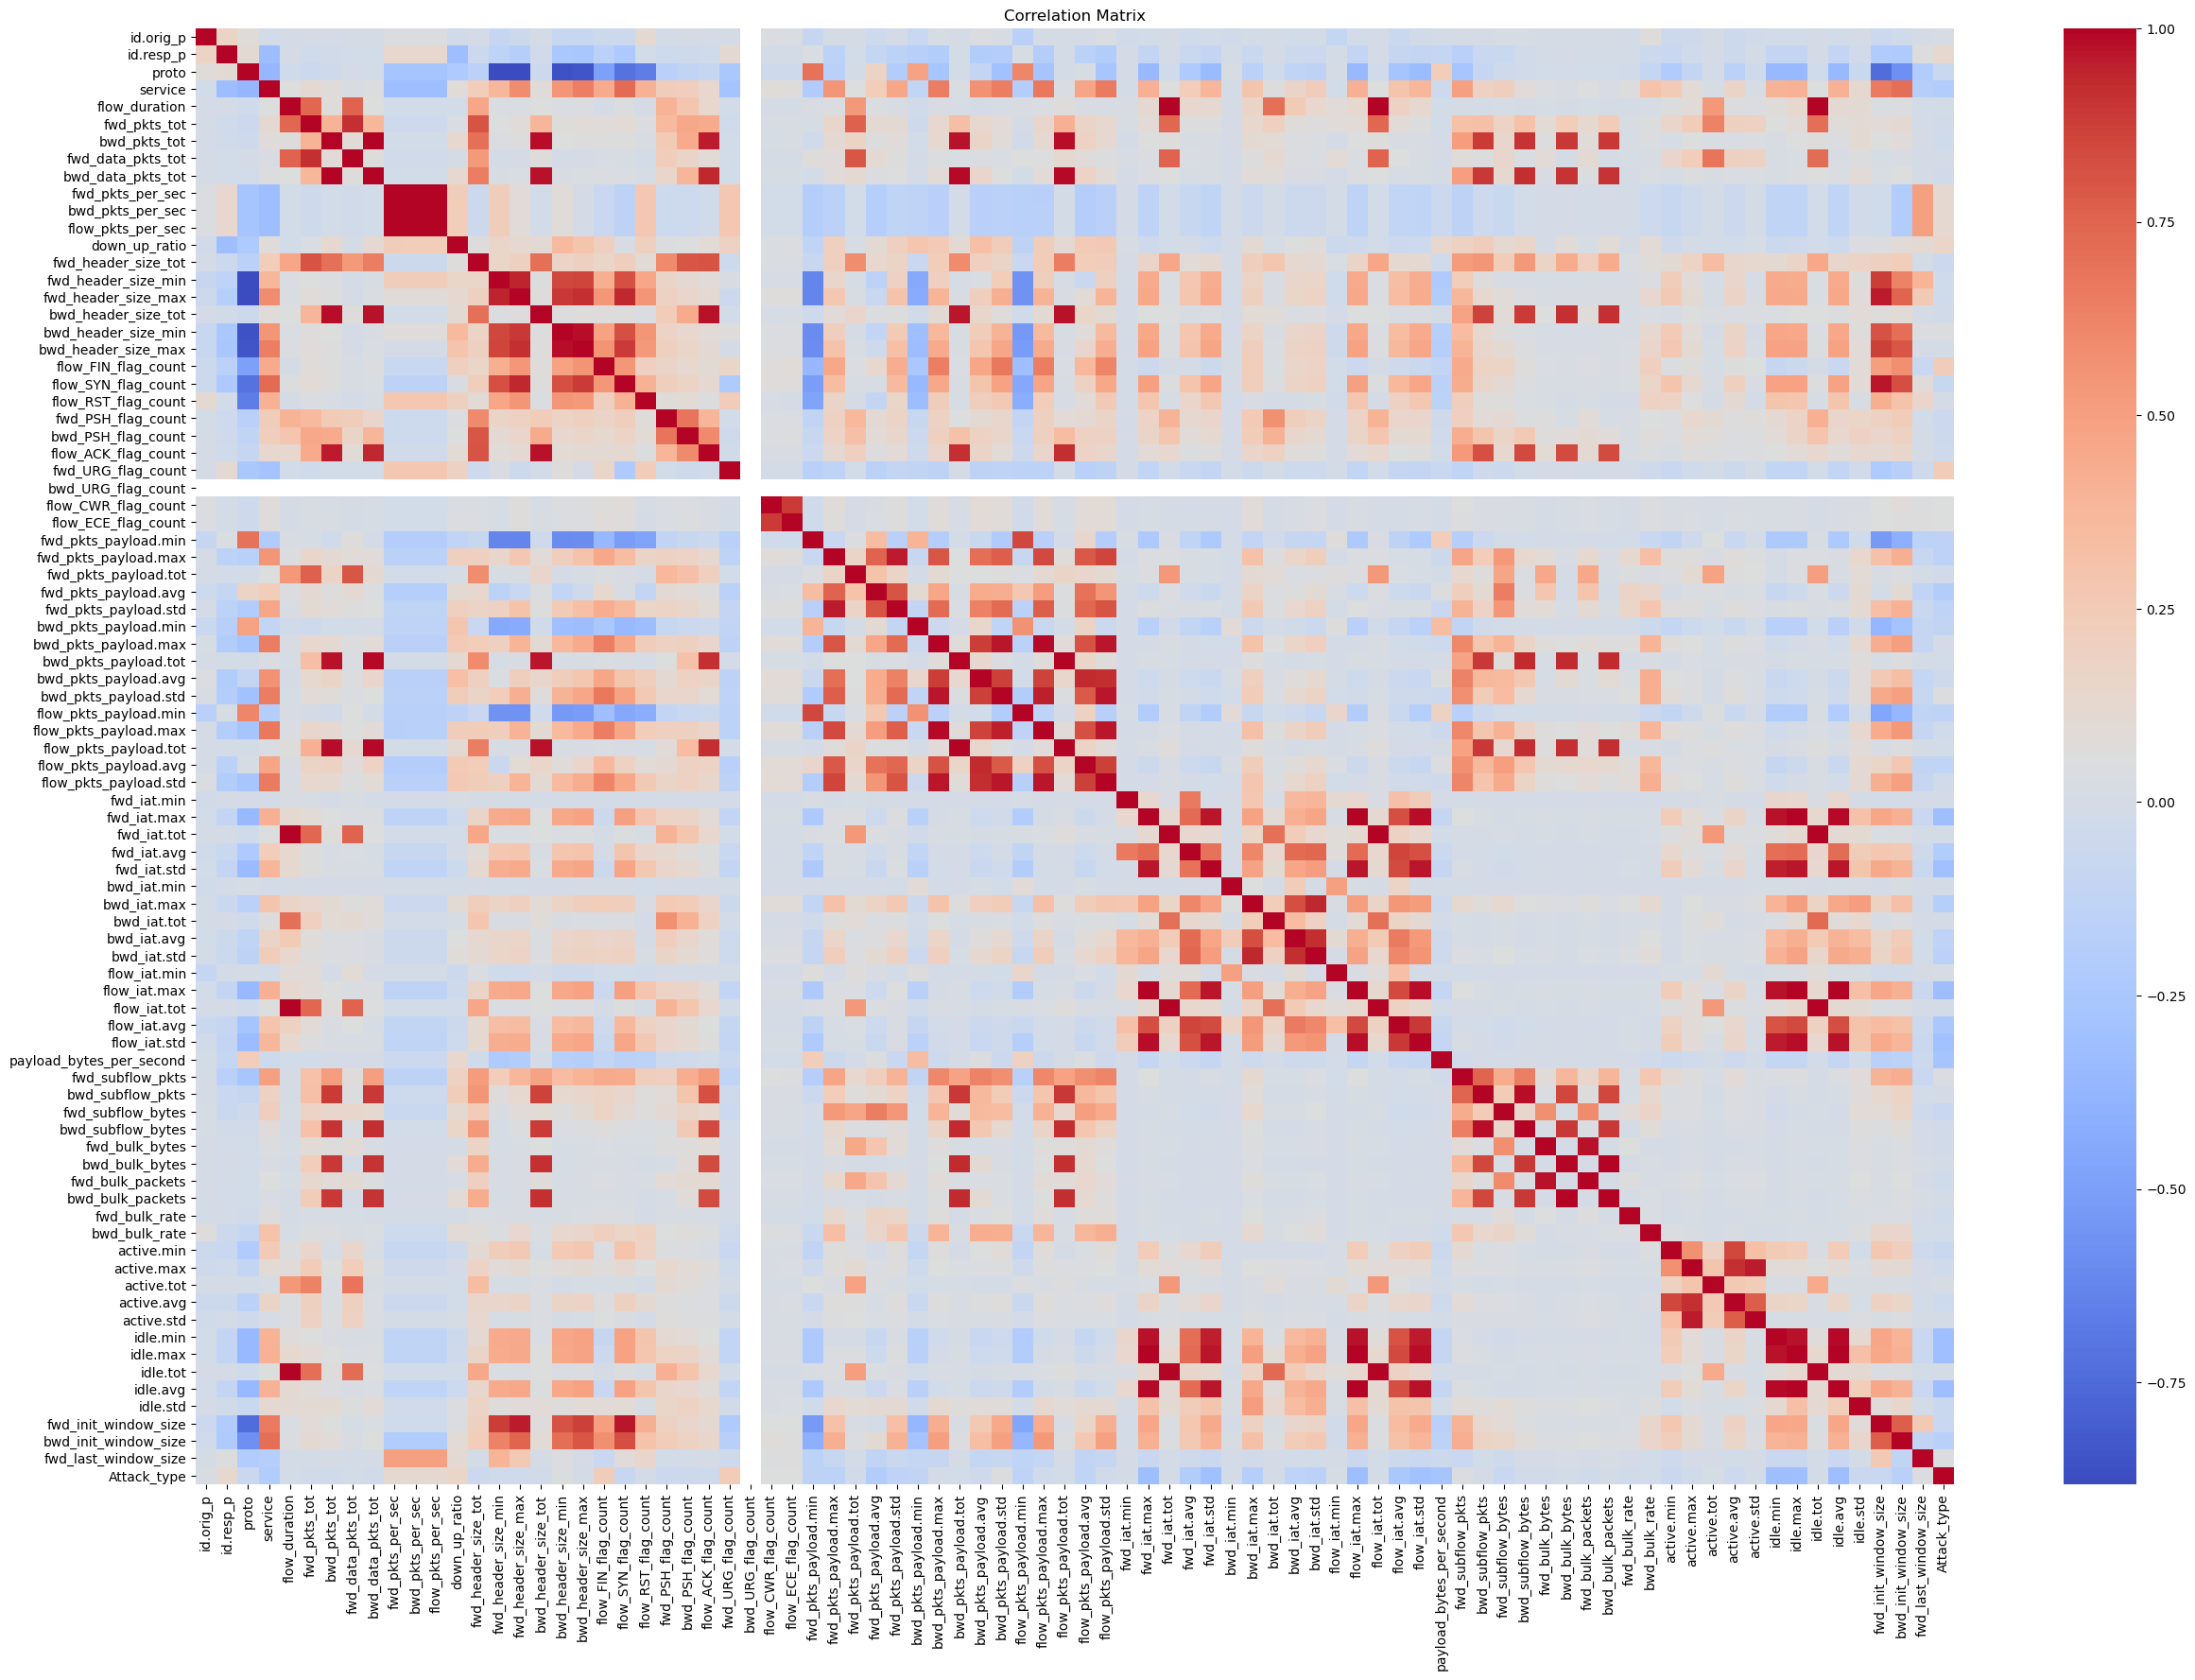

In [24]:
correlation_matrix = df.corr()
plt.figure(figsize=(30, 20))  
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

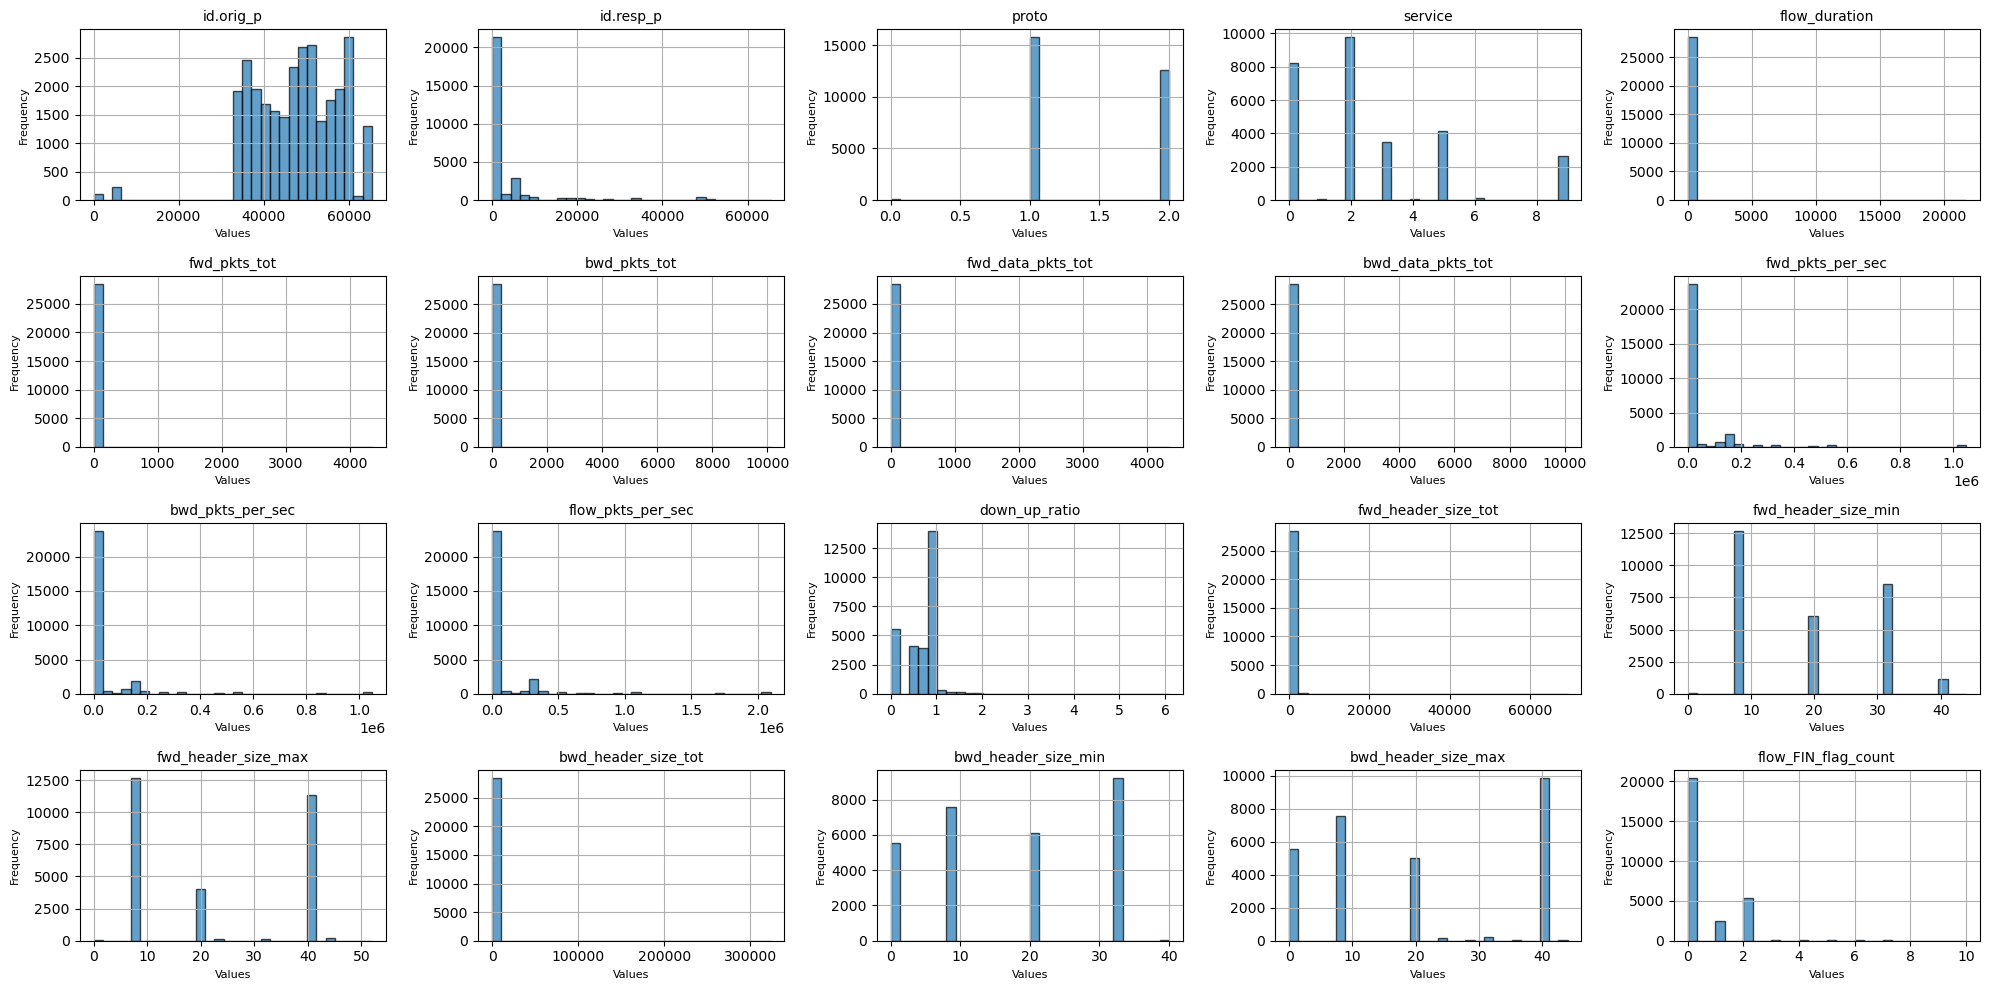

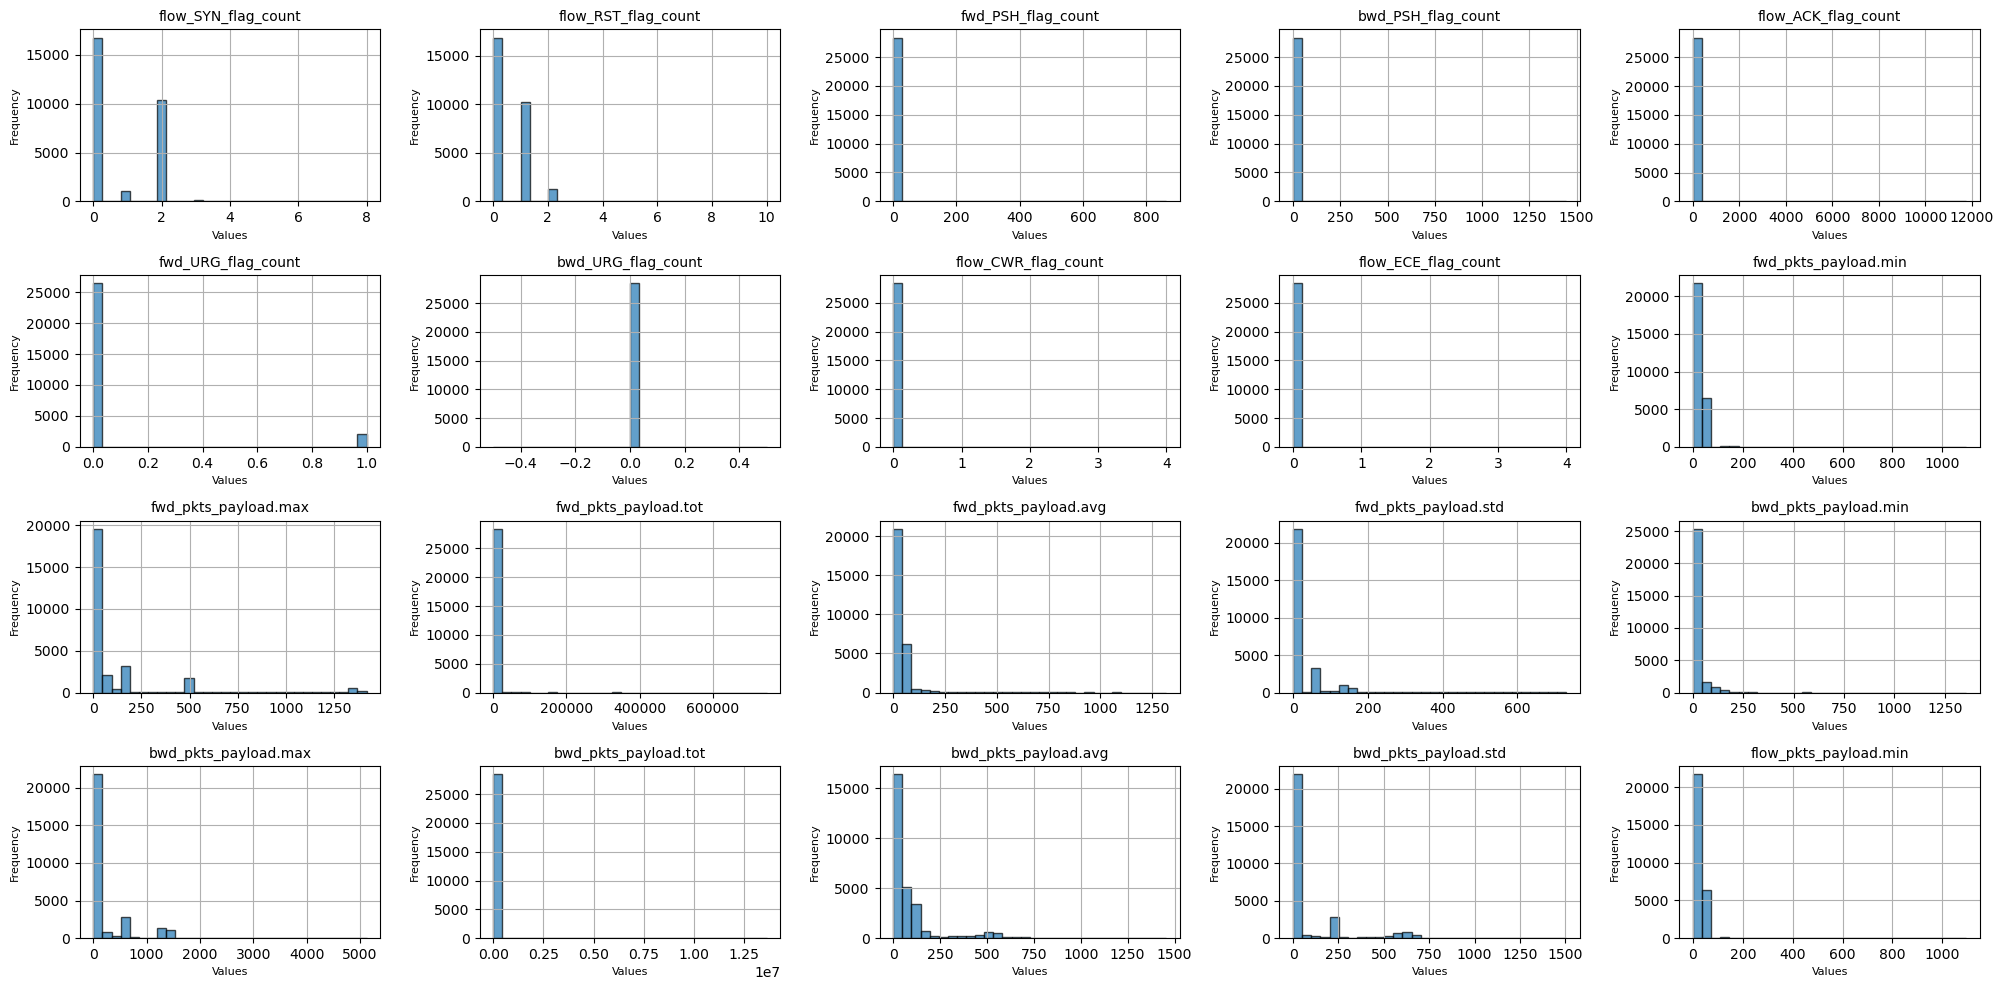

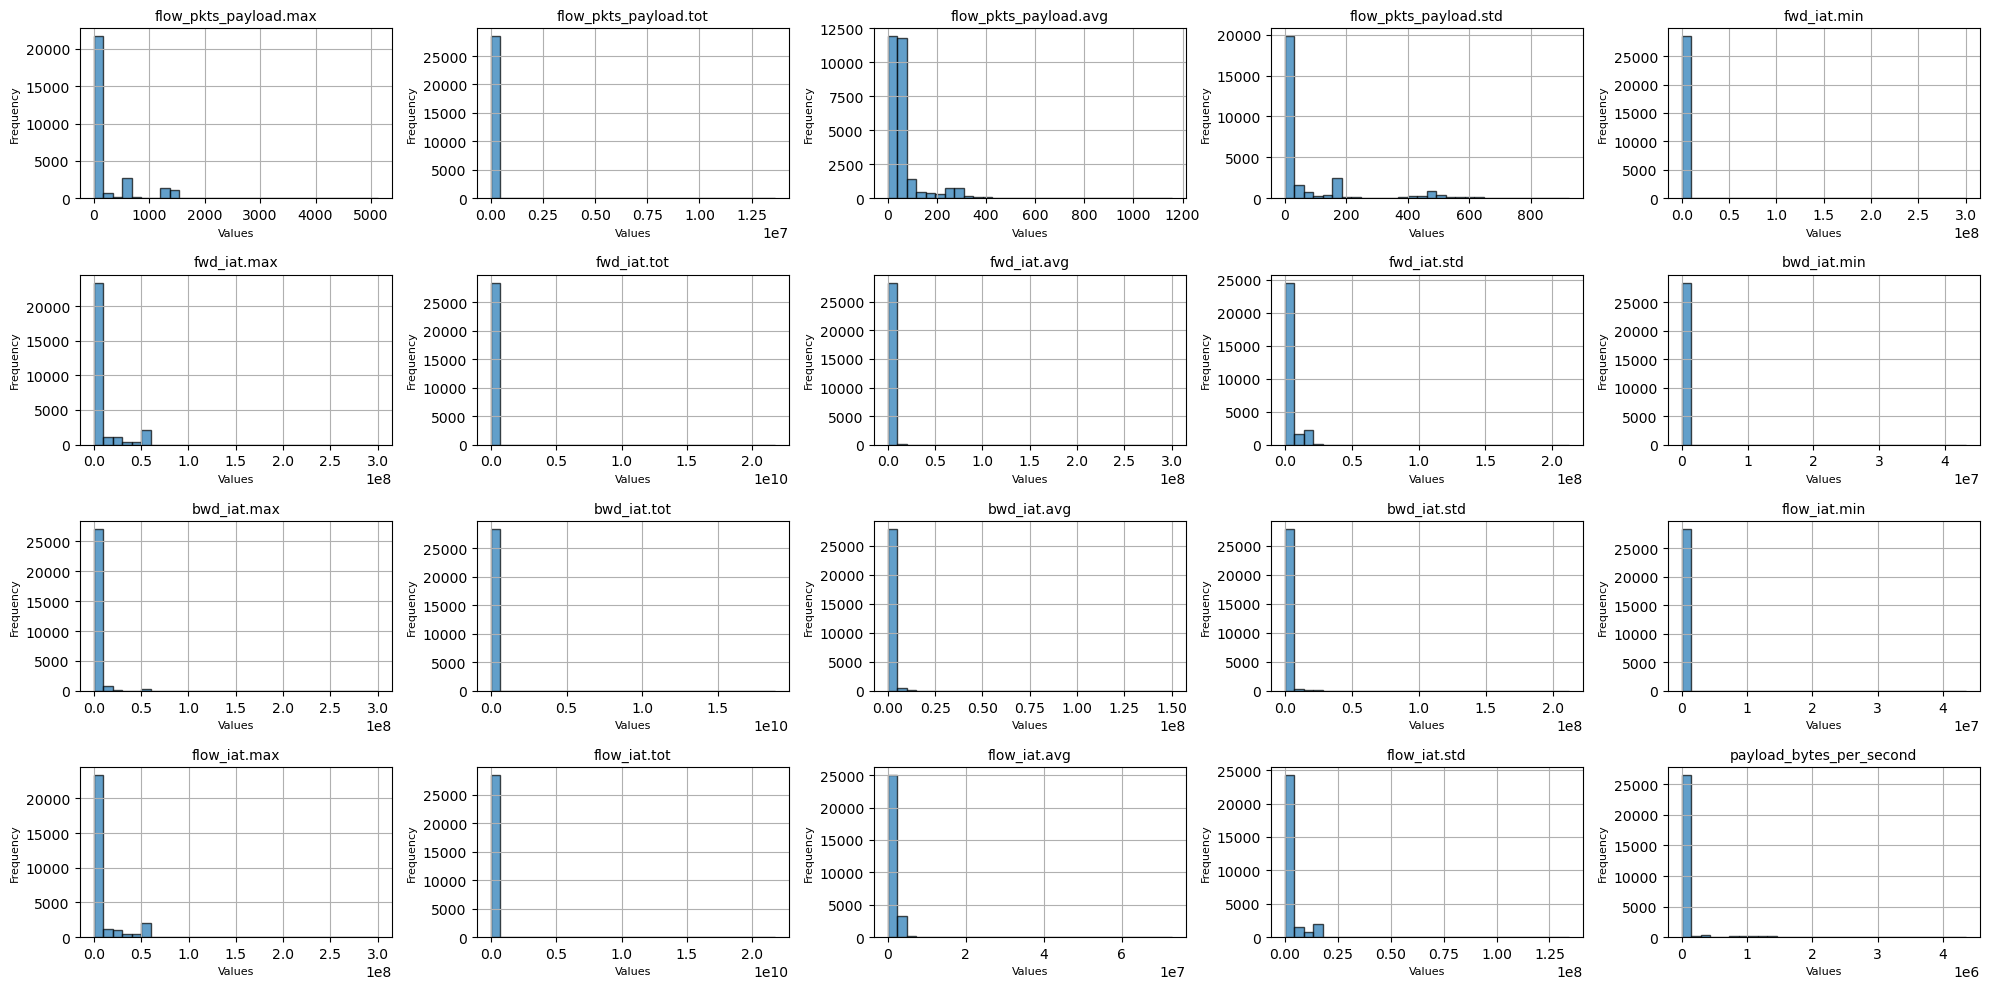

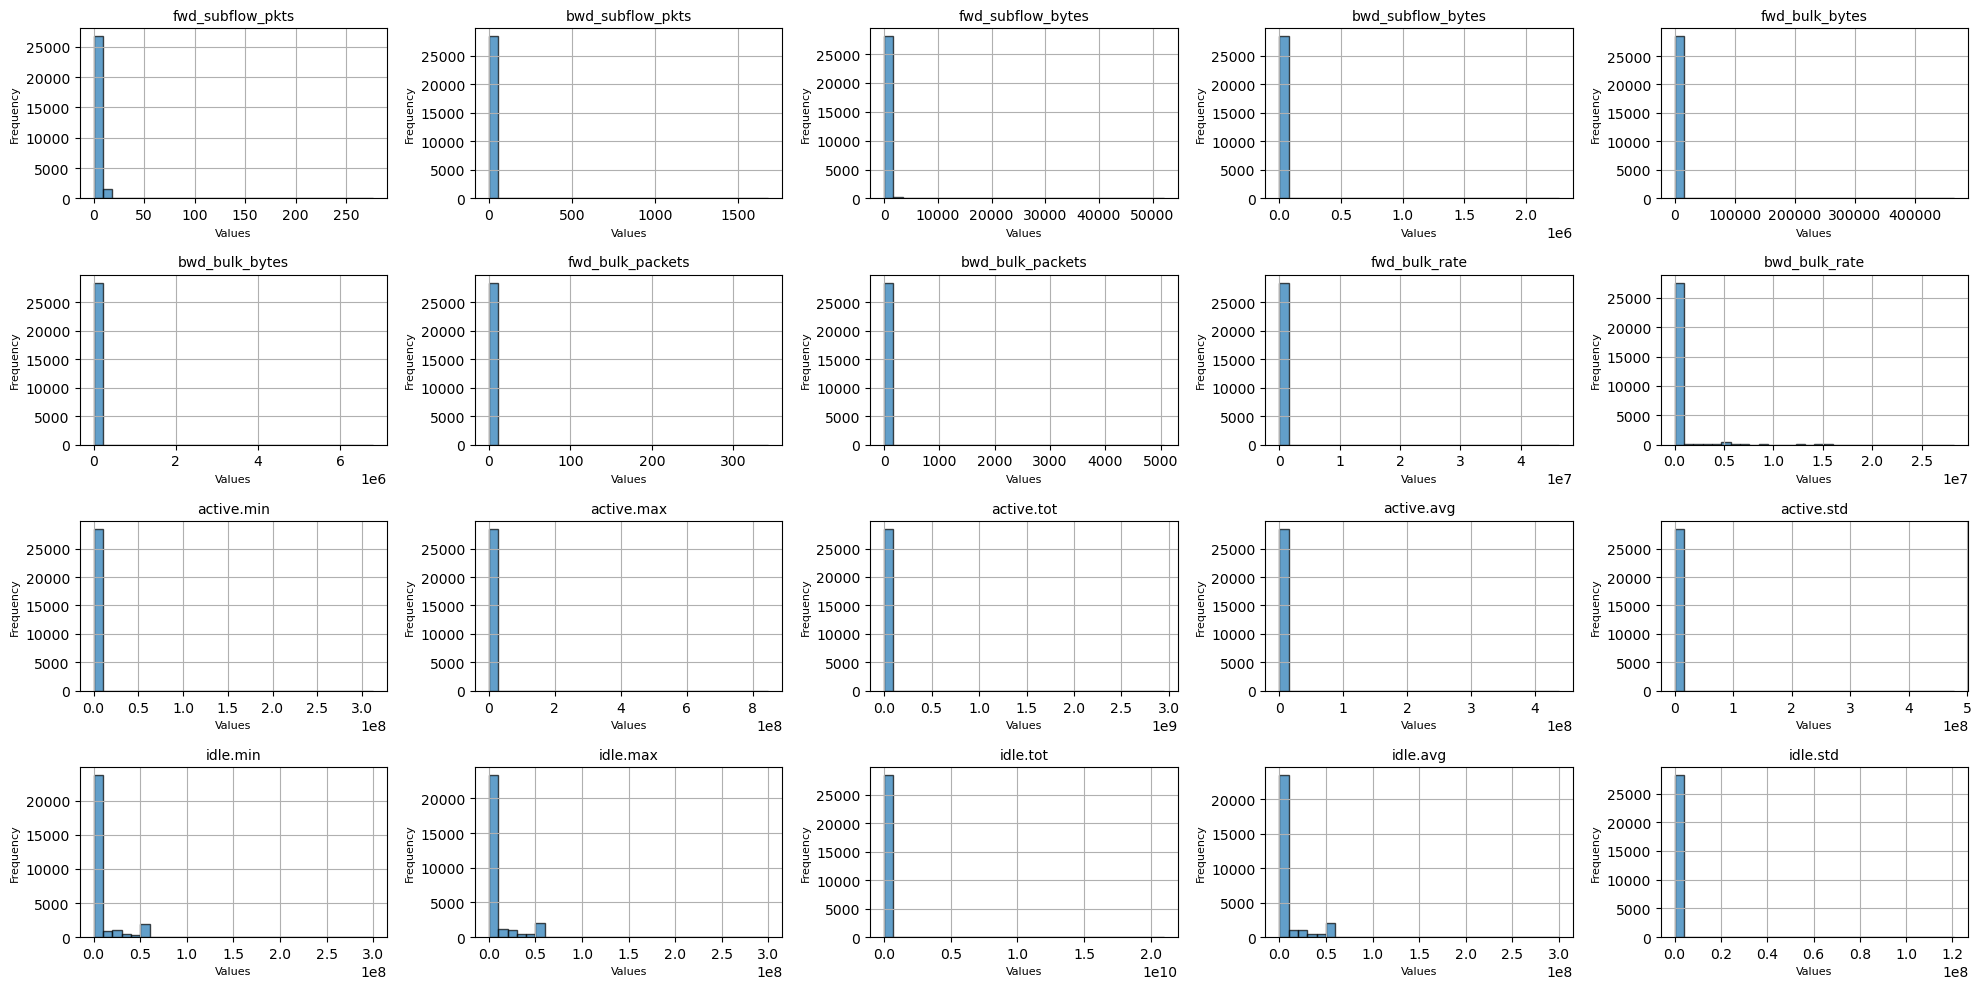

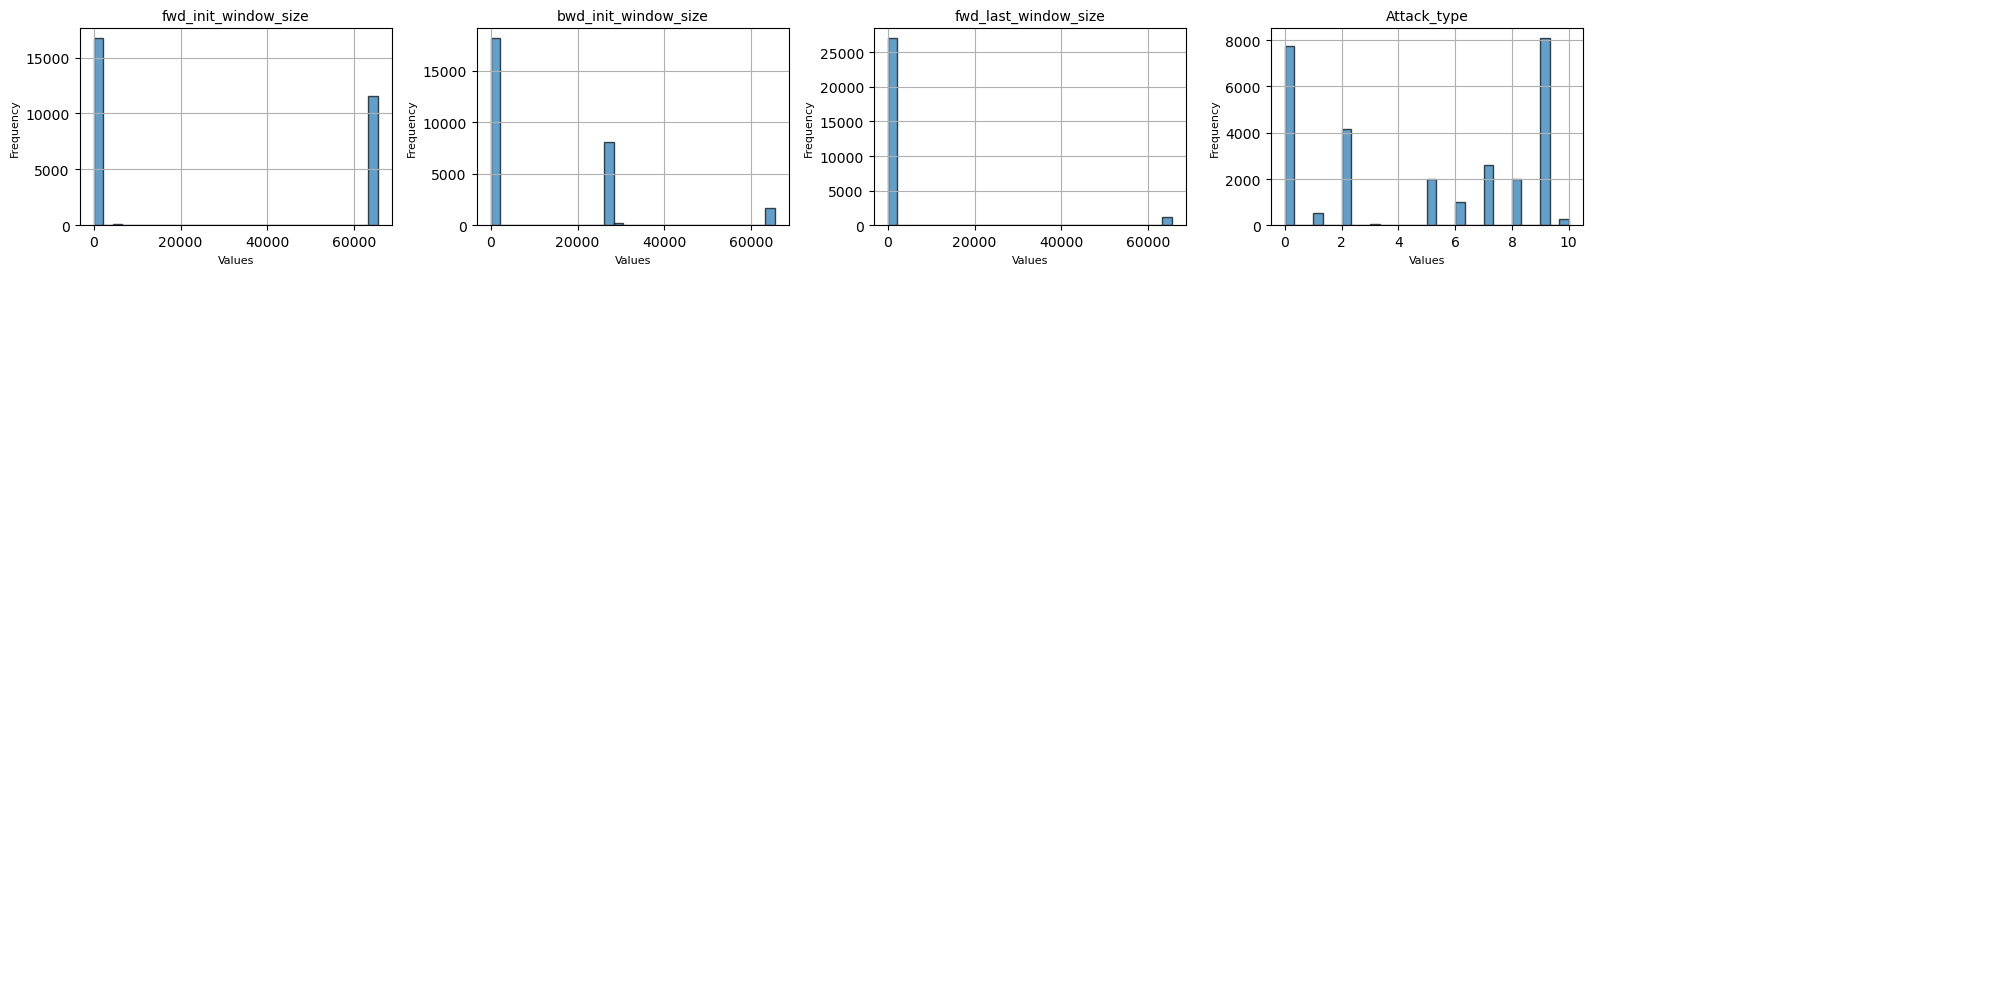

In [25]:
def plot_feature_distributions_grid(data, feature_ranges):
    for start, end in feature_ranges:
        features = data.iloc[:, start:end]
        num_features = features.shape[1]
        grid_size = (4, 5)  

        fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 10))
        axes = axes.flatten() 

        for i, col in enumerate(features.columns):
            ax = axes[i]
            ax.hist(features[col], bins=30, edgecolor='k', alpha=0.7)
            ax.set_title(f"{col}", fontsize=10)
            ax.set_xlabel("Values", fontsize=8)
            ax.set_ylabel("Frequency", fontsize=8)
            ax.grid(True)

        for i in range(num_features, len(axes)):
            axes[i].axis('off')
            
        plt.tight_layout()
        plt.show()
        
feature_ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80,84)]
plot_feature_distributions_grid(df, feature_ranges)


Top 5 Features with Highest Variance:
Index(['flow_iat.tot', 'fwd_iat.tot', 'idle.tot', 'bwd_iat.tot', 'active.tot'], dtype='object')


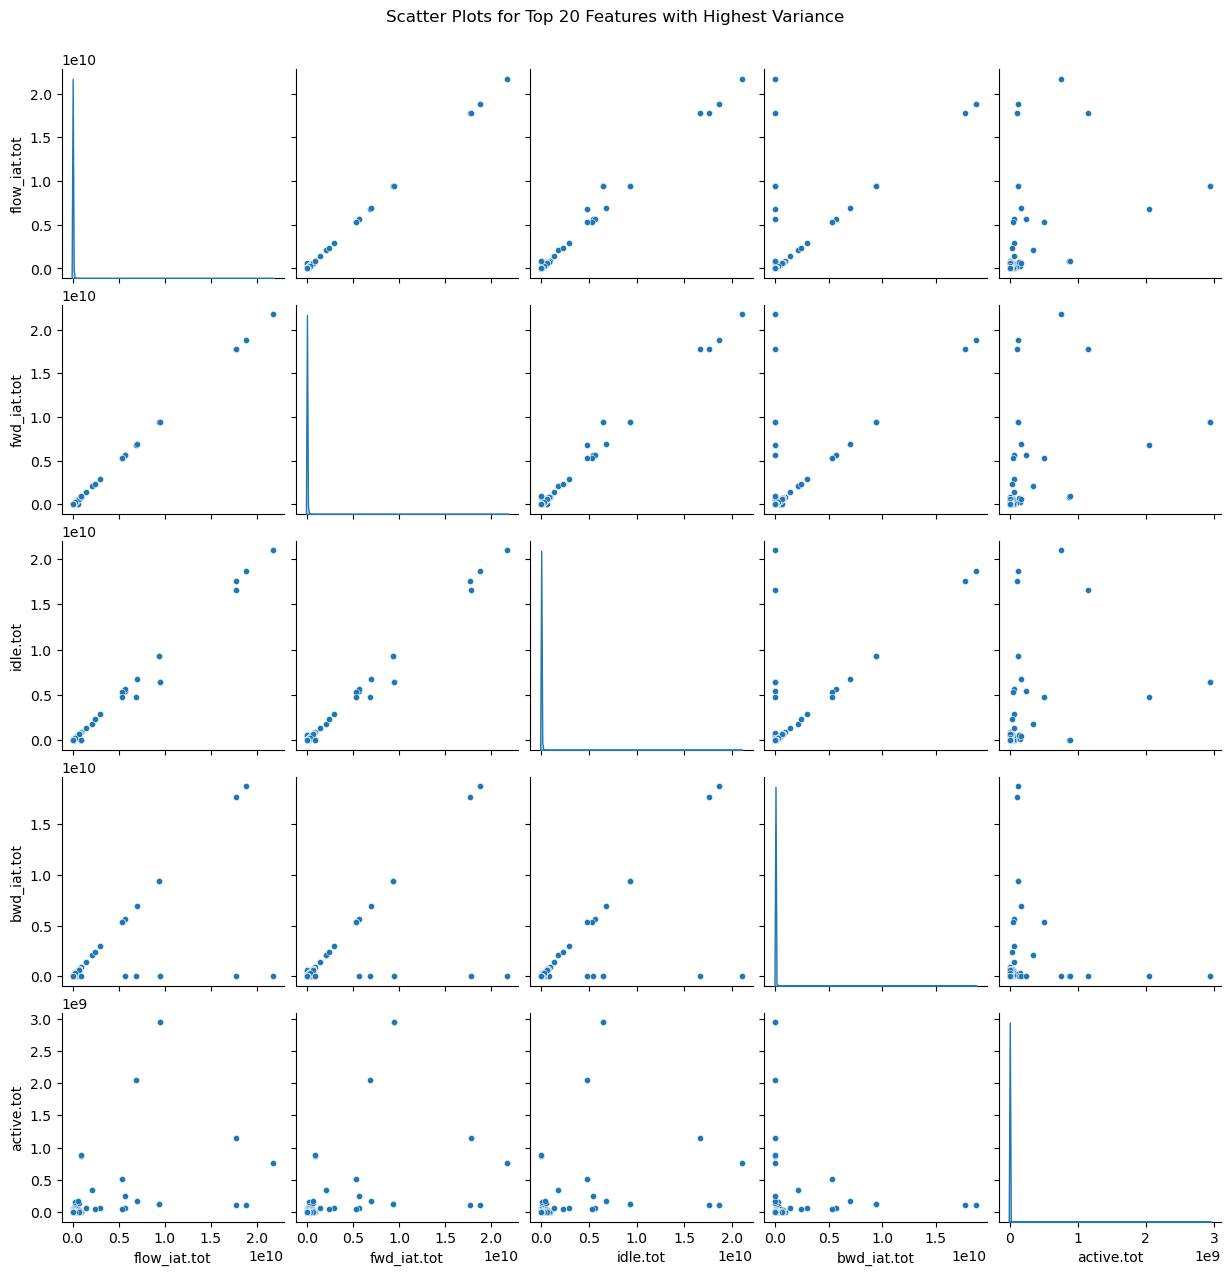

In [26]:
numeric_df = df.select_dtypes(include=[np.number]) 

feature_variance = numeric_df.var()

sorted_features = feature_variance.sort_values(ascending=False)

top_5_features = sorted_features.head(5).index
print("Top 5 Features with Highest Variance:")
print(top_5_features)

top_5_df = numeric_df[top_5_features]
pairplot = sns.pairplot(top_5_df, diag_kind="kde", plot_kws={'alpha':1, 's':20})  
pairplot.fig.suptitle("Scatter Plots for Top 20 Features with Highest Variance", y=1.02)
plt.show()


### Task 2. interpretation


### 1. Correlation Matrix Insights

**Clustered Groups of Correlated Features:**
- There appear to be distinct blocks of features that are strongly correlated with each other. For instance:
  - **Forward/Backward Traffic Groups:** Metrics related to forward-direction packets (e.g., `fwd_pkts_tot`, `fwd_data_pkts_tot`, `fwd_pkts_payload.*`) tend to form a tight cluster, indicating that if one forward-based metric increases, the others often increase as well.
  - **Backward Traffic Groups:** Similarly, backward-direction metrics (`bwd_pkts_tot`, `bwd_pkts_payload.*`, `bwd_header_size.*`) cluster together, suggesting a parallel set of strongly interrelated features.
  - **Flow-Level Time Statistics:** Features like `flow_duration`, `flow_iat.*` may correlate among themselves, reflecting that certain timing characteristics move together.
  
**Implications for Feature Selection:**
- The presence of highly correlated features indicates potential redundancy. Many features measure similar aspects of network flows, just from slightly different angles. This redundancy could be simplified by using techniques like Principal Component Analysis (PCA), or by selecting a subset of representative features to reduce complexity and avoid collinearity issues in modeling.

**Negative Correlations:**
- Some features may show a negative correlation (blueish hues), which can highlight trade-offs. For example, certain packet size metrics might inversely correlate with packet rates, or certain timing metrics (like large idle times) may correlate negatively with the number of packets transferred.

---

### 2. Histograms and Distribution Analysis

**Highly Skewed Distributions:**
- Most features display heavily skewed distributions with a large proportion of values near zero or very low, and a few instances showing extremely high values. This is common in network traffic data, where normal flows might be small and bursty while certain attacks or anomalies produce large, unusual values.
- For features like `fwd_pkts_per_sec` or `flow_data_pkts_tot`, the majority of data points cluster in lower ranges, while some outliers reach very high magnitudes.

**Discrete and Categorical Features:**
- Features like `proto` (often indicating protocol type, e.g., TCP, UDP) and `service` (application-layer protocol such as HTTP, DNS, MQTT) show a small number of distinct categories. The histograms for these features have only a few bins with values, indicating limited categorical variety.

**Class (Attack_type) Distribution:**
- The histogram for `Attack_type` shows that the dataset contains multiple categories, likely different attack signatures plus benign traffic. The distribution may not be uniform; some attack types appear more frequently than others.
- Imbalanced classes could pose challenges for classification tasks and may require careful handling (e.g., class weighting or resampling).

**Implications for Modeling:**
- The presence of long-tailed distributions suggests that normalization or transformation (e.g., log-scaling) might improve model performance.
- Models that are robust to skewed data or that can handle outliers well (like tree-based methods) may perform better without extensive feature engineering.

---

### 3. Scatter Plots of High-Variance Features

**Linear and Non-Linear Relationships:**
- The scatter plots for the top 20 features with the highest variance often show linear patterns between certain pairs (e.g., total forward bytes vs. total forward packets). Such relationships confirm the strong correlations found in the correlation matrix.
- Some plots show that while most points cluster near an origin (low values for both features), a few outliers occupy extreme ranges. This pattern underscores the data’s heterogeneity.

**Visual Outliers and Data Quality:**
- Vertical or horizontal lines of points (where one feature does not vary while the other does) may indicate certain network behaviors or potential data quality artifacts.
- Extreme spikes or abrupt changes could represent unusual traffic bursts, potentially linked to specific attack behaviors.

---

## Part 3: Implementing Classification Algorithms

### Task 1. Split the dataset

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Task 2. Classification Algorithms

In [33]:
class KNNClassifierScratch:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)  

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = np.linalg.norm(self.X_train - x, axis=1)
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = self.y_train[k_indices]
        # Return the most common class label
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common


In [34]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=3000):
        self.learning_rate = learning_rate  # Learning rate for gradient descent
        self.epochs = epochs  # Number of training iterations
        self.weights = None  # Weight matrix to be learned
        self.bias = None  # Bias vector to be learned

    def softmax(self, z):
        # Apply softmax function with numerical stability
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def initialize_weights(self, n_features, n_classes):
        # Initialize weights and bias to zeros
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]  # Number of samples
        # Compute cross-entropy loss
        loss = -(1 / m) * np.sum(y_true * np.log(y_pred))
        return loss

    def fit(self, X, y):
        n_samples, n_features = X.shape  # Get sample and feature counts
        n_classes = len(np.unique(y))  # Determine number of classes
        self.initialize_weights(n_features, n_classes)  # Initialize parameters

        # Convert labels to one-hot encoding
        y_one_hot = np.zeros((n_samples, n_classes))
        y_one_hot[np.arange(n_samples), y] = 1

        for epoch in range(self.epochs):
            # Compute linear combination
            linear_model = np.dot(X, self.weights) + self.bias

            # Apply softmax to get predictions
            y_pred = self.softmax(linear_model)

            # Calculate gradients for weights and bias
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y_one_hot))
            db = (1 / n_samples) * np.sum(y_pred - y_one_hot, axis=0)

            # Update weights and bias using gradient descent
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        # Compute linear combination
        linear_model = np.dot(X, self.weights) + self.bias
        # Apply softmax to get probabilities
        y_pred = self.softmax(linear_model)
        # Return class with highest probability
        return np.argmax(y_pred, axis=1)


In [35]:
class DecisionTreeClassifierScratch:
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
            self.feature = feature          # Feature index to split on
            self.threshold = threshold      # Threshold value for the split
            self.left = left                # Left child node
            self.right = right              # Right child node
            self.value = value              # Class label if it's a leaf node

        def is_leaf_node(self):
            return self.value is not None    # Check if the node is a leaf

    def __init__(self, max_depth=10, min_samples_split=2, max_features=None):
        self.max_depth = max_depth                    # Maximum depth of the tree
        self.min_samples_split = min_samples_split    # Minimum samples required to split
        self.max_features = max_features              # Number of features to consider for splits
        self.root = None                              # Root node of the tree

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        n_samples, n_features = X.shape
        self.n_samples = n_samples
        self.n_features = n_features

        self.max_features = self.max_features or n_features  # Use all features if not specified

        # Pre-sort indices for each feature to speed up threshold finding
        self.feature_sorted_indices = [np.argsort(X[:, f]) for f in range(n_features)]
        
        self.X = X  # Store training data
        self.y = y  # Store training labels
        
        self.root = self._build_tree(np.arange(n_samples), depth=0)  # Build the tree

    def _build_tree(self, samples_indices, depth=0):
        y = self.y[samples_indices]
        n_samples = len(samples_indices)
        n_labels = len(np.unique(y))
        
        # Stopping conditions
        if (depth >= self.max_depth or 
            n_labels == 1 or 
            n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return self.Node(value=leaf_value)

        # Select random subset of features if max_features < total features
        features_to_consider = np.random.choice(self.n_features, self.max_features, replace=False)

        best_feat, best_thresh, best_gain = None, None, -1
        current_entropy = self._entropy(y)
        
        for feat_idx in features_to_consider:
            sorted_idx = self.feature_sorted_indices[feat_idx][np.in1d(self.feature_sorted_indices[feat_idx], samples_indices)]
            X_column = self.X[sorted_idx, feat_idx]
            y_sorted = self.y[sorted_idx]

            parent_counts = np.bincount(y_sorted, minlength=np.max(y_sorted)+1)
            left_counts = np.zeros_like(parent_counts)
            right_counts = parent_counts.copy()
            
            for i in range(1, n_samples):
                c = y_sorted[i-1]
                left_counts[c] += 1
                right_counts[c] -= 1

                if X_column[i] == X_column[i-1]:
                    continue  # Skip identical values

                threshold = (X_column[i] + X_column[i-1]) / 2.0  # Midpoint threshold

                left_entropy = self._entropy_from_counts(left_counts)
                right_entropy = self._entropy_from_counts(right_counts)
                child_entropy = (i / n_samples) * left_entropy + ((n_samples - i) / n_samples) * right_entropy
                gain = current_entropy - child_entropy

                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat_idx
                    best_thresh = threshold
                    best_split = (sorted_idx[:i], sorted_idx[i:])  # Indices for left and right splits

        if best_gain == -1:
            leaf_value = self._most_common_label(y)
            return self.Node(value=leaf_value)

        # Recursively build left and right subtrees
        left_node = self._build_tree(best_split[0], depth + 1)
        right_node = self._build_tree(best_split[1], depth + 1)
        return self.Node(feature=best_feat, threshold=best_thresh, left=left_node, right=right_node)

    def _entropy(self, y):
        counts = np.bincount(y, minlength=np.max(y)+1)
        return self._entropy_from_counts(counts)

    def _entropy_from_counts(self, counts):
        ps = counts / np.sum(counts)
        return -np.sum(ps[ps > 0] * np.log2(ps[ps > 0]))  # Calculate entropy

    def _most_common_label(self, y):
        return np.bincount(y, minlength=np.max(y)+1).argmax()  # Majority class

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])  # Predict for each sample

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value  # Return class label if leaf
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)  # Traverse left subtree
        return self._traverse_tree(x, node.right)     # Traverse right subtree


### Task 3. Evaluation of Classification Algorithms

In [37]:
def evaluate_model(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

KNN Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1546
           1       0.96      0.96      0.96       114
           2       1.00      1.00      1.00       810
           3       1.00      0.78      0.88         9
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00       400
           6       0.99      0.99      0.99       190
           7       1.00      0.99      0.99       521
           8       1.00      1.00      1.00       411
           9       0.99      0.98      0.98      1638
          10       1.00      0.88      0.93        48

    accuracy                           0.99      5692
   macro avg       0.97      0.94      0.96      5692
weighted avg       0.99      0.99      0.99      5692



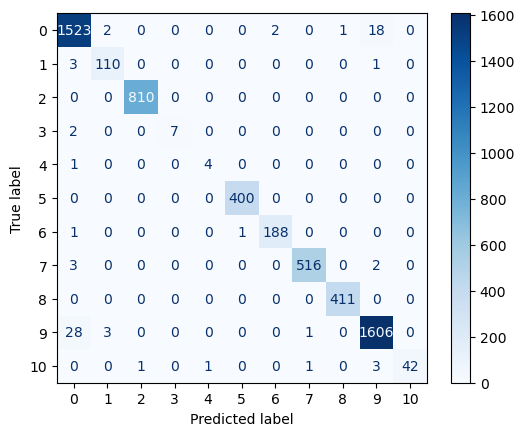

In [38]:
# K-Nearest Neighbors
knn_model = KNNClassifierScratch(k=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("KNN Evaluation:")
evaluate_model(y_test, knn_pred)

Logistic Regression Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1546
           1       0.00      0.00      0.00       114
           2       0.93      1.00      0.96       810
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       1.00      1.00      1.00       400
           6       0.91      0.99      0.95       190
           7       0.93      0.60      0.73       521
           8       1.00      1.00      1.00       411
           9       0.90      0.93      0.91      1638
          10       0.00      0.00      0.00        48

    accuracy                           0.88      5692
   macro avg       0.59      0.58      0.58      5692
weighted avg       0.86      0.88      0.87      5692



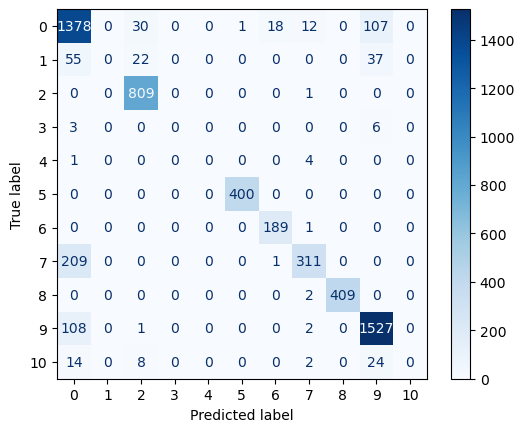

In [39]:
# Logistic Regression
lr_model = LogisticRegressionScratch(learning_rate=0.01, epochs=3000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("Logistic Regression Evaluation:")
evaluate_model(y_test, lr_pred)

Decision Tree Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1546
           1       0.80      0.97      0.88       114
           2       1.00      1.00      1.00       810
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       1.00      1.00      1.00       400
           6       1.00      0.99      1.00       190
           7       0.97      0.94      0.96       521
           8       1.00      1.00      1.00       411
           9       0.92      0.97      0.95      1638
          10       0.95      0.79      0.86        48

    accuracy                           0.96      5692
   macro avg       0.78      0.78      0.78      5692
weighted avg       0.96      0.96      0.96      5692



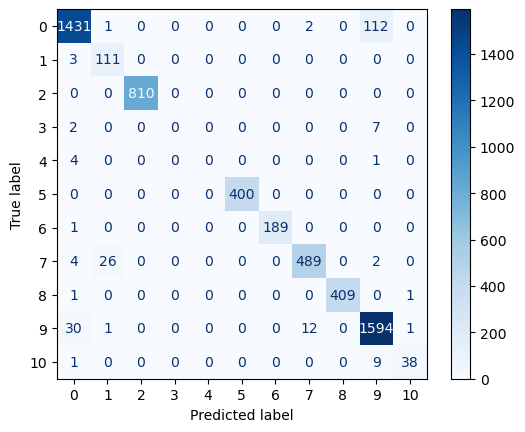

In [40]:
# Decision Tree
dt_model = DecisionTreeClassifierScratch(max_depth=5)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
print("Decision Tree Evaluation:")
evaluate_model(y_test, dt_pred)

In [41]:
# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare arrays to store cross-validation results
knn_scores = []
lr_scores = []
dt_scores = []

for train_index, test_index in kf.split(X, y):
    # Split the data into train and test subsets for this fold
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # --- KNN Cross-Validation ---
    knn_model = KNNClassifierScratch(k=5)
    knn_model.fit(X_train_cv, y_train_cv)
    knn_pred_cv = knn_model.predict(X_test_cv)
    knn_acc = np.mean(knn_pred_cv == y_test_cv)
    knn_scores.append(knn_acc)

    # --- Logistic Regression Cross-Validation ---
    lr_model = LogisticRegressionScratch(learning_rate=0.01, epochs=3000)
    lr_model.fit(X_train_cv, y_train_cv)
    lr_pred_cv = lr_model.predict(X_test_cv)
    lr_acc = np.mean(lr_pred_cv == y_test_cv)
    lr_scores.append(lr_acc)

    # --- Decision Tree Cross-Validation ---
    dt_model = DecisionTreeClassifierScratch(max_depth=5)
    dt_model.fit(X_train_cv, y_train_cv)
    dt_pred_cv = dt_model.predict(X_test_cv)
    dt_acc = np.mean(dt_pred_cv == y_test_cv)
    dt_scores.append(dt_acc)

# After running through all folds, compute average performance
print("KNN CV average accuracy:", np.mean(knn_scores))
print("Logistic Regression CV average accuracy:", np.mean(lr_scores))
print("Decision Tree CV average accuracy:", np.mean(dt_scores))


KNN CV average accuracy: 0.9853467514697233
Logistic Regression CV average accuracy: 0.8865346129116347
Decision Tree CV average accuracy: 0.9613464899331255


---

### Performance Summary Tables

**Classification Metrics (From Provided Reports)**

| Model               | Accuracy | Macro Avg Precision | Macro Avg Recall | Macro Avg F1 | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1 |
|---------------------|----------|---------------------|------------------|--------------|------------------------|---------------------|-----------------|
| KNN                 | 0.99     | 0.97                | 0.94             | 0.96         | 0.99                   | 0.99                | 0.99            |
| Logistic Regression | 0.88     | 0.59                | 0.58             | 0.58         | 0.86                   | 0.88                | 0.87            |
| Decision Tree       | 0.96     | 0.78                | 0.78             | 0.78         | 0.96                   | 0.96                | 0.96            |

**Cross-Validation Accuracy**

| Model               | CV Average Accuracy |
|---------------------|---------------------|
| KNN                 | 0.9853             |
| Logistic Regression | 0.8865             |
| Decision Tree       | 0.9614             |

---

### Interpretation of Results

1. **K-Nearest Neighbors (KNN):**  
   - **Performance:** KNN achieves the highest accuracy (~99%) and near-perfect precision and recall for most classes. Almost all classes, including smaller and potentially rarer ones, are well classified.
   - **Reasoning:**  
     - **Non-Linear Decision Boundaries:** KNN makes no assumptions about linearity. It can adapt to complex data structures by using local proximity.  
     - **Data Distribution:** If the dataset’s features are well-separated in their feature space, KNN can excel by simply identifying the correct "neighborhood" around a test instance.

2. **Logistic Regression:**  
   - **Performance:** Logistic Regression shows the lowest accuracy (~88%) of the three models and struggles with several classes, particularly those that are less frequent or not linearly separable (e.g., classes 1, 3, 4, and 10 have very low or zero recall).
   - **Reasoning:**  
     - **Linearity Assumption:** Logistic Regression relies on a linear decision boundary. If the feature relationships are complex or non-linear, logistic regression may fail to distinguish certain classes accurately.  
     - **Class Overlap:** Some classes may not be well separated by linear hyperplanes, causing the model to misclassify them.

3. **Decision Tree:**  
   - **Performance:** Decision Tree’s accuracy (~96%) is high but not as high as KNN. Most classes are well predicted, but it struggles with a few classes (like 3 and 4) possibly due to their limited number of samples or noisiness.
   - **Reasoning:**  
     - **Non-Linear Boundaries:** Decision trees naturally capture non-linear relationships and variable interactions, leading to better performance than logistic regression.  
     - **Small Class Issues:** Decision trees can be sensitive to class imbalance or very small classes. If certain classes have very few samples, the tree may not split effectively to isolate them.

---

### Why One Model Might Outperform the Others

- **KNN vs. Logistic Regression:**  
  KNN outperforms logistic regression because the data likely isn’t linearly separable. KNN is a non-parametric model that can handle complex boundaries, clustering classes in feature space without imposing a linear structure. Logistic Regression’s linear decision surface is too simplistic for such nuanced data patterns.

- **KNN vs. Decision Tree:**  
  While both KNN and Decision Trees can model non-linear decision boundaries, KNN wins out here potentially due to the data distribution and the distance metrics used. If the data clusters well, KNN can robustly classify points based on proximity. Decision trees, though powerful, can be affected by small class sizes or particular splitting criteria, sometimes leading to suboptimal splits or slight overfitting. The KNN model might be benefiting from the ability to leverage a rich neighborhood structure, especially if hyperparameters (like the number of neighbors) are well-tuned.

- **Decision Tree vs. Logistic Regression:**  
  Decision Trees outperform logistic regression because they are not restricted to a linear decision boundary. They can model higher-order interactions between features and easily capture complex patterns in the data. Logistic Regression’s inability to represent non-linearities without additional feature transformations makes it less flexible.

---

### Conclusion

The KNN model provides the best overall performance, likely due to its flexibility in modeling complex, non-linear relationships in the data. Logistic Regression’s poorer performance suggests the data cannot be effectively separated by a linear boundary. Decision Trees, while good, still fall short of KNN’s accuracy, possibly due to class imbalances, noisy features, or insufficient splits for rarer classes.

In [43]:
# Random Forest (using sklearn)
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
importances = rfc_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print("Top 30 Features by Importance:\n", feature_importance_df.head(30))

Top 30 Features by Importance:
                   feature  importance
32   fwd_pkts_payload.avg    0.056495
44            fwd_iat.min    0.055282
54           flow_iat.min    0.048046
22     fwd_PSH_flag_count    0.045717
42  flow_pkts_payload.avg    0.040032
19    flow_FIN_flag_count    0.036745
82   fwd_last_window_size    0.034261
3                 service    0.031767
70             active.min    0.030303
0               id.orig_p    0.028385
40  flow_pkts_payload.max    0.027119
62      fwd_subflow_bytes    0.024541
73             active.avg    0.021109
1               id.resp_p    0.020960
13    fwd_header_size_tot    0.019375
38   bwd_pkts_payload.std    0.019166
29   fwd_pkts_payload.min    0.017679
35   bwd_pkts_payload.max    0.015533
71             active.max    0.015492
31   fwd_pkts_payload.tot    0.015386
45            fwd_iat.max    0.015209
53            bwd_iat.std    0.014246
37   bwd_pkts_payload.avg    0.014013
41  flow_pkts_payload.tot    0.013810
15    fwd_header_s

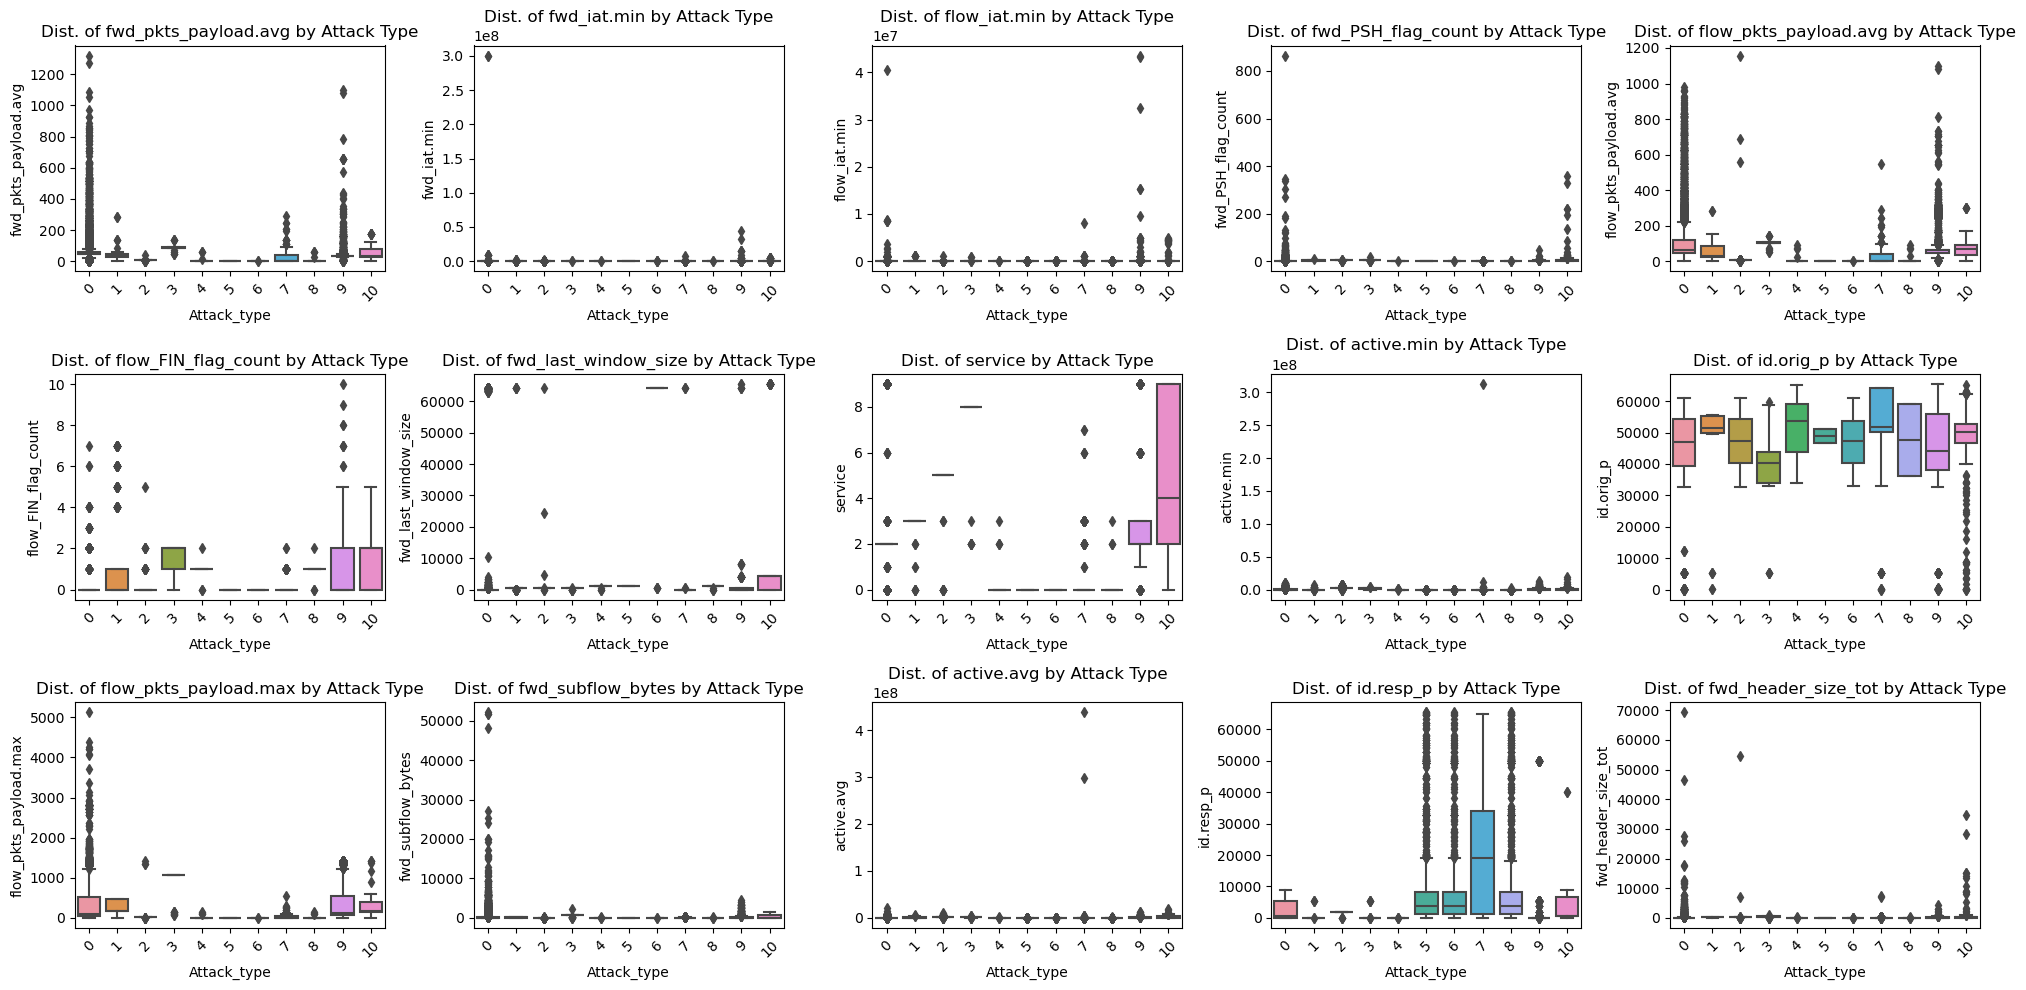

In [45]:
top_15_features = feature_importance_df.head(15)['feature'].values

# Create a 2x5 grid for plots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes array to iterate easily

# Plot each of the top 10 features in a separate subplot
for i, feat in enumerate(top_15_features):
    sns.boxplot(x='Attack_type', y=feat, data=df, ax=axes[i])
    axes[i].set_title(f"Dist. of {feat} by Attack Type")
    
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In [46]:
top_15_features

array(['fwd_pkts_payload.avg', 'fwd_iat.min', 'flow_iat.min',
       'fwd_PSH_flag_count', 'flow_pkts_payload.avg',
       'flow_FIN_flag_count', 'fwd_last_window_size', 'service',
       'active.min', 'id.orig_p', 'flow_pkts_payload.max',
       'fwd_subflow_bytes', 'active.avg', 'id.resp_p',
       'fwd_header_size_tot'], dtype=object)


---

### Commentary on the Graph (Boxplots)

The provided graph shows a series of boxplots illustrating the distribution of selected top features for each attack type. Each subplot corresponds to one of the initially most important features identified by the Random Forest classifier.

**Key Observations from the Boxplots:**

1. **Distinctive Value Ranges for Certain Features:**  
   Some features, like `fwd_pkts_payload.avg` and `flow_pkts_payload.max`, show markedly different value distributions for one or two attack types compared to others. For instance, one particular attack type might have consistently higher values, effectively “giving away” its identity.

2. **Outliers and Skewed Distributions:**  
   Many boxplots exhibit heavy skew or numerous outliers. These extreme values might represent certain attacks that generate unusual traffic patterns (e.g., extremely large packet sizes or abnormal inter-arrival times).

3. **Feature-Dominated Classification:**  
   When a single feature can separate one class cleanly from the rest (e.g., `fwd_iat.min` being near zero for one class but very large for another), the classification becomes too trivial. These “giveaway” features lead to near-perfect performance without capturing the more nuanced patterns of the other features.

In summary, the boxplots confirm that certain top features hold disproportionate discriminative power for specific attack types, making classification too easy and potentially masking deeper relationships in the data.



In [48]:
# Convert X to DataFrame
X = pd.DataFrame(X, columns=feature_names)  

# Suppose top_feature is making classification trivial. Let's drop it:
X_reduced = X.drop(columns=['fwd_pkts_payload.avg', 'fwd_iat.min', 'flow_iat.min',
       'fwd_PSH_flag_count', 'flow_pkts_payload.avg',
       'flow_FIN_flag_count', 'fwd_last_window_size', 'service',
       'active.min', 'id.orig_p', 'flow_pkts_payload.max',
       'fwd_subflow_bytes', 'active.avg', 'id.resp_p',
       'fwd_header_size_tot'])
X_reduced = scaler.fit_transform(X_reduced)
# Retrain models without the top feature
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

KNN Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1546
           1       0.88      0.92      0.90       114
           2       1.00      1.00      1.00       810
           3       0.88      0.78      0.82         9
           4       0.57      0.80      0.67         5
           5       0.52      0.50      0.51       400
           6       0.99      0.99      0.99       190
           7       0.90      0.97      0.94       521
           8       0.53      0.56      0.55       411
           9       0.99      0.97      0.98      1638
          10       0.95      0.85      0.90        48

    accuracy                           0.91      5692
   macro avg       0.83      0.85      0.84      5692
weighted avg       0.91      0.91      0.91      5692



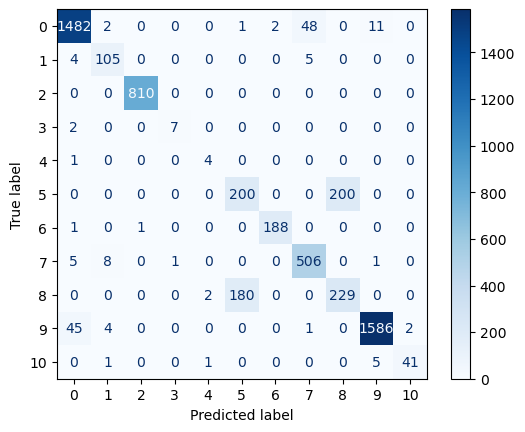

In [49]:
# K-Nearest Neighbors
knn_model = KNNClassifierScratch(k=5)
knn_model.fit(X_train_red, y_train_red)
knn_pred = knn_model.predict(X_test_red)
print("KNN Evaluation:")
evaluate_model(y_test_red, knn_pred)

Logistic Regression Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1546
           1       0.00      0.00      0.00       114
           2       0.92      1.00      0.96       810
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       0.49      1.00      0.66       400
           6       0.98      0.99      0.99       190
           7       0.90      0.60      0.72       521
           8       0.00      0.00      0.00       411
           9       0.82      0.91      0.86      1638
          10       0.00      0.00      0.00        48

    accuracy                           0.78      5692
   macro avg       0.44      0.48      0.45      5692
weighted avg       0.72      0.78      0.74      5692



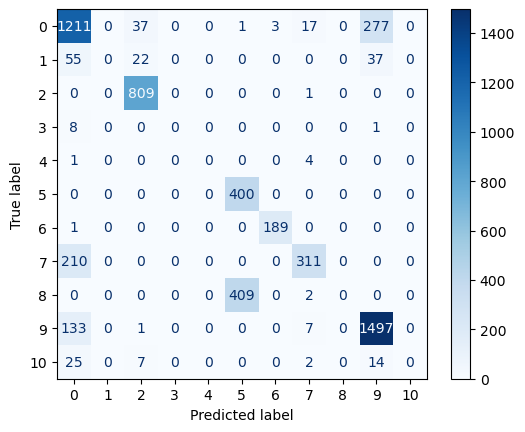

In [50]:
# Logistic Regression
lr_model = LogisticRegressionScratch(learning_rate=0.01, epochs=3000)
lr_model.fit(X_train_red, y_train_red)
lr_pred = lr_model.predict(X_test_red)
print("Logistic Regression Evaluation:")
evaluate_model(y_test_red, lr_pred)

Decision Tree Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1546
           1       0.59      0.96      0.73       114
           2       1.00      1.00      1.00       810
           3       0.00      0.00      0.00         9
           4       0.40      0.80      0.53         5
           5       0.65      0.28      0.39       400
           6       1.00      0.99      1.00       190
           7       0.90      0.88      0.89       521
           8       0.55      0.85      0.67       411
           9       0.91      0.97      0.94      1638
          10       0.29      0.25      0.27        48

    accuracy                           0.87      5692
   macro avg       0.66      0.71      0.67      5692
weighted avg       0.88      0.87      0.87      5692



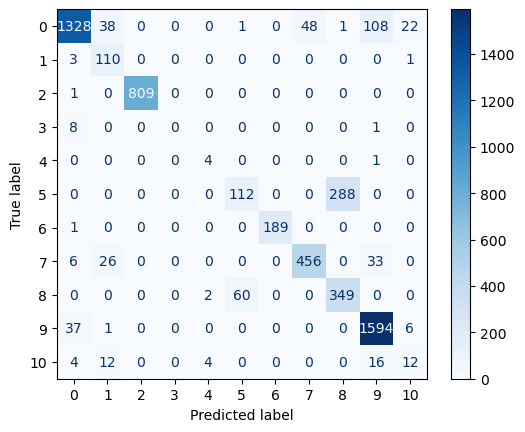

In [51]:
# Decision Tree
dt_model = DecisionTreeClassifierScratch(max_depth=5)
dt_model.fit(X_train_red, y_train_red)
dt_pred = dt_model.predict(X_test_red)
print("Decision Tree Evaluation:")
evaluate_model(y_test_red, dt_pred)

In [52]:
# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare arrays to store cross-validation results
knn_scores = []
lr_scores = []
dt_scores = []

for train_index, test_index in kf.split(X_reduced, y):
    # Split the data into train and test subsets for this fold
    X_train_cv, X_test_cv = X_reduced[train_index], X_reduced[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # --- KNN Cross-Validation ---
    knn_model = KNNClassifierScratch(k=5)
    knn_model.fit(X_train_cv, y_train_cv)
    knn_pred_cv = knn_model.predict(X_test_cv)
    knn_acc = np.mean(knn_pred_cv == y_test_cv)
    knn_scores.append(knn_acc)

    # --- Logistic Regression Cross-Validation ---
    lr_model = LogisticRegressionScratch(learning_rate=0.01, epochs=3000)
    lr_model.fit(X_train_cv, y_train_cv)
    lr_pred_cv = lr_model.predict(X_test_cv)
    lr_acc = np.mean(lr_pred_cv == y_test_cv)
    lr_scores.append(lr_acc)

    # --- Decision Tree Cross-Validation ---
    dt_model = DecisionTreeClassifierScratch(max_depth=5)
    dt_model.fit(X_train_cv, y_train_cv)
    dt_pred_cv = dt_model.predict(X_test_cv)
    dt_acc = np.mean(dt_pred_cv == y_test_cv)
    dt_scores.append(dt_acc)

# After running through all folds, compute average performance
print("KNN CV average accuracy:", np.mean(knn_scores))
print("Logistic Regression CV average accuracy:", np.mean(lr_scores))
print("Decision Tree CV average accuracy:", np.mean(dt_scores))


KNN CV average accuracy: 0.9045607697819775
Logistic Regression CV average accuracy: 0.7783750600280824
Decision Tree CV average accuracy: 0.8759925641119679


---

### Comparison of Model Performance: Before vs. After Feature Removal

**Before Feature Removal:**
- **KNN:** Accuracy was extremely high (~99%). The presence of certain dominant features allowed KNN to achieve near-perfect classification.  
- **Logistic Regression:** Achieved ~88% accuracy. While not as flexible as KNN, logistic regression still benefited from a few highly informative features but struggled with non-linearity and some underrepresented classes.  
- **Decision Tree:** Had about ~96% accuracy, also leveraging the strongest features to easily split certain classes.

**After Feature Removal:**
- After removing the top 15 features that were identified as “too powerful,” the scenario becomes more challenging.
  
| Model               | Accuracy Before | Accuracy After  | CV Average Before | CV Average After |
|---------------------|-----------------|-----------------|------------------|-----------------|
| KNN                 | ~0.99           | ~0.91           | ~0.9853           | ~0.9046          |
| Logistic Regression | ~0.88           | ~0.78           | ~0.8865           | ~0.7784          |
| Decision Tree       | ~0.96           | ~0.87           | ~0.9614           | ~0.8760          |

**Interpretation of Changes:**

1. **Overall Accuracy Drop:**  
   All three models see their accuracy and cross-validation scores decrease significantly after removing top features. This confirms that those features were indeed heavily influencing the classification decision, providing simple shortcuts for the model to achieve high accuracy.

2. **More Realistic Performance:**
   With trivial features removed, the models rely on a broader range of attributes, capturing more subtle differences in network traffic. While performance is lower, it may now better reflect the underlying complexity of the task.

3. **Model Differences Remain:**
   - **KNN:** Still outperforms Logistic Regression and Decision Tree, indicating it can adapt well to the underlying structure even without the most discriminative features.
   - **Logistic Regression:** Suffers the most from feature removal, reinforcing that its linear boundary is too simplistic without straightforward, dominant features.
   - **Decision Tree:** Remains competitive, but less dominant. The tree can still find splits among the remaining features, but without the key features, its task is more difficult.

---

### Conclusion

- **Before Removal:** The classifiers, especially KNN and Decision Tree, performed exceptionally well, largely due to a handful of features that made distinguishing certain classes nearly trivial.
- **After Removal:** By removing these dominant features, classification became more challenging and performance dropped. This trade-off reveals the true complexity of the dataset and ensures that the final model captures richer patterns rather than relying on “giveaway” features.

**In essence, the boxplots and the before/after performance metrics highlight the importance of identifying and potentially removing overly discriminative features for a more robust and generalizable classification model.**

## Part 4: Implementing Clustering Algorithms

### Task 1. Clustering Algorithms

In [56]:
# Load dataset
data = pd.read_csv("data_4.csv")

# Columns to encode
columns_to_encode = ['proto', 'service', 'Attack_type']

# Dictionary to store mappings
label_encoders = {}

# Apply Label Encoding
for column in columns_to_encode:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = dict(zip(le.classes_, range(len(le.classes_))))

# Display mappings for each column
for column, mapping in label_encoders.items():
    print(f"Mapping for {column}: {mapping}")

Mapping for proto: {'icmp': 0, 'tcp': 1, 'udp': 2}
Mapping for service: {'-': 0, 'dhcp': 1, 'dns': 2, 'http': 3, 'irc': 4, 'mqtt': 5, 'ntp': 6, 'radius': 7, 'ssh': 8, 'ssl': 9}
Mapping for Attack_type: {'ARP_poisioning': 0, 'DDOS_Slowloris': 1, 'MQTT_Publish': 2, 'Metasploit_Brute_Force_SSH': 3, 'NMAP_FIN_SCAN': 4, 'NMAP_OS_DETECTION': 5, 'NMAP_TCP_scan': 6, 'NMAP_UDP_SCAN': 7, 'NMAP_XMAS_TREE_SCAN': 8, 'Thing_Speak': 9, 'Wipro_bulb': 10}


In [57]:
X = data.drop('Attack_type', axis=1)
y = data['Attack_type']

In [58]:
class KMeansScratch:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters      # Number of clusters
        self.max_iter = max_iter          # Maximum number of iterations
        self.tol = tol                    # Tolerance for convergence
        self.centroids = None             # Centroid coordinates
        self.labels = None                # Cluster assignments

    def fit(self, X):
        n_samples, n_features = X.shape
        # Initialize centroids by randomly selecting data points
        self.centroids = X[random.sample(range(n_samples), self.n_clusters)]
        
        for _ in range(self.max_iter):
            # Assign each sample to the nearest centroid
            self.labels = [self._closest_centroid(x) for x in X]
            
            # Compute new centroids as the mean of assigned samples
            new_centroids = np.array([
                X[np.array(self.labels) == i].mean(axis=0) 
                for i in range(self.n_clusters)
            ])
            
            # Check for convergence based on centroid movement
            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) < self.tol):
                break  # Stop if centroids have stabilized
            
            self.centroids = new_centroids  # Update centroids

    def _closest_centroid(self, x):
        # Compute distances from x to each centroid
        distances = np.linalg.norm(self.centroids - x, axis=1)
        return np.argmin(distances)  # Return index of nearest centroid

    def predict(self, X):
        # Assign each sample in X to the nearest centroid
        return [self._closest_centroid(x) for x in X]


In [59]:
# Agglomerative Clustering
class AgglomerativeClusteringScratch:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters  # Desired number of clusters
        self.labels = None            # Cluster labels after fitting

    def fit(self, X):
        X = np.array(X)  # Ensure input is a NumPy array
        dist = self._compute_distances(X)  # Compute pairwise distances
        n = X.shape[0]  # Number of samples

        pi, lambda_arr = self._slink(dist)  # Apply SLINK algorithm
        self.labels = self._form_clusters_from_slink(pi, lambda_arr, n)  # Determine cluster assignments

    def predict(self):
        return self.labels  # Return cluster labels

    def _compute_distances(self, X):
        """Compute all pairwise Euclidean distances."""
        n_samples = X.shape[0]
        distances = np.full((n_samples, n_samples), np.inf, dtype=float)  # Initialize distance matrix
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                d = np.linalg.norm(X[i] - X[j])  # Compute Euclidean distance
                distances[i, j] = d
                distances[j, i] = d  # Symmetric matrix
        return distances

    def _slink(self, dist):
        """
        SLINK algorithm for single-linkage hierarchical clustering in O(n^2).
        """
        n = dist.shape[0]
        pi = np.zeros(n, dtype=int)        # Parent pointers
        lambda_arr = np.zeros(n, dtype=float)  # Merge distances

        for i in range(1, n):
            lambda_arr[i] = np.inf
            pi[i] = i
            for j in range(i):
                d_ij = dist[i, j]
                if d_ij < lambda_arr[i]:
                    lambda_arr[i], pi[i] = d_ij, pi[j]
                    pi[j] = i
                elif d_ij < lambda_arr[j]:
                    temp = lambda_arr[j]
                    lambda_arr[j], pi[j] = d_ij, i
                    i = pi[j]
                    pi[j] = pi[i]
                    lambda_arr[i] = temp
        return pi, lambda_arr

    def _form_clusters_from_slink(self, pi, lambda_arr, n):
        """
        Form clusters from SLINK's pi and lambda arrays.
        """
        parent = np.arange(n)  # Initialize Union-Find structure
        size = np.ones(n, dtype=int)

        def find(x):
            while parent[x] != x:
                parent[x] = parent[parent[x]]  # Path compression
                x = parent[x]
            return x

        def union(a, b):
            rootA = find(a)
            rootB = find(b)
            if rootA != rootB:
                if size[rootA] < size[rootB]:
                    rootA, rootB = rootB, rootA
                parent[rootB] = rootA
                size[rootA] += size[rootB]
                return True
            return False

        # Create list of merges: (distance, a, b)
        merges = []
        for i in range(1, n):
            a, b = i, pi[i]
            merges.append((lambda_arr[i], a, b))

        merges.sort(key=lambda x: x[0])  # Sort merges by distance

        merges_to_do = n - self.n_clusters  # Number of merges needed
        for dist_val, a, b in merges:
            if merges_to_do <= 0:
                break
            if union(a, b):
                merges_to_do -= 1

        # Assign cluster labels based on final parent assignments
        labels = np.zeros(n, dtype=int)
        roots = {}
        cluster_id = 0
        for i in range(n):
            root = find(i)
            if root not in roots:
                roots[root] = cluster_id
                cluster_id += 1
            labels[i] = roots[root]

        return labels


In [60]:
# DBSCAN Clustering
class DBSCANScratch:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps  # Radius to consider for neighborhood
        self.min_samples = min_samples  # Minimum points to form a dense region
        self.labels = None  # Cluster labels after fitting
        self.tree = None  # BallTree for spatial indexing

    def fit(self, X):
        X = np.array(X)  # Ensure input is a NumPy array
        n_samples = X.shape[0]
        self.labels = np.full(n_samples, -1)  # Initialize all labels as noise (-1)
        visited = np.zeros(n_samples, dtype=bool)  # Track visited points

        self.tree = BallTree(X)  # Build spatial index for efficient neighbor search

        cluster_id = 0  # Initialize cluster identifier
        for i in range(n_samples):
            if not visited[i]:
                visited[i] = True  # Mark point as visited
                neighbors = self._region_query(X, i)  # Find neighbors within eps

                if len(neighbors) >= self.min_samples:
                    self._expand_cluster(X, i, neighbors, cluster_id, visited)
                    cluster_id += 1  # Move to next cluster ID

    def _region_query(self, X, point_idx):
        # Find all points within eps distance of the point at point_idx
        neighbors = self.tree.query_radius(X[point_idx].reshape(1, -1), r=self.eps)
        return neighbors[0].tolist()  # Return as a list of indices

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id, visited):
        self.labels[point_idx] = cluster_id  # Assign cluster ID to the point
        i = 0
        while i < len(neighbors):
            neighbor = neighbors[i]
            if not visited[neighbor]:
                visited[neighbor] = True  # Mark neighbor as visited
                new_neighbors = self._region_query(X, neighbor)  # Find neighbors of neighbor
                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors  # Add new neighbors to the list
            if self.labels[neighbor] == -1:
                self.labels[neighbor] = cluster_id  # Assign cluster ID to noise point
            i += 1  # Move to next neighbor

    def predict(self):
        return self.labels  # Return cluster labels


---

### 1. Strengths and Weaknesses of Each Algorithm

**K-Means Clustering:**
- **Strengths:**
  - **Simplicity & Speed:** K-Means is fast and easy to implement, making it a common first choice for clustering.
  - **Works Well with Spherical Clusters:** If clusters are roughly spherical and well separated in the feature space, K-Means can perform quite effectively.
  
- **Weaknesses:**
  - **Sensitivity to Initialization and Scale:** K-Means is sensitive to feature scales. Without normalization, features with large numeric ranges dominate the distance metric.
  - **Assumption of Spherical Clusters:** It tries to minimize variance within each cluster, leading it to favor equally sized, globular clusters. If the data doesn’t conform to that shape, performance degrades.
  - **Hard Assignment and Outliers:** Outliers can heavily influence cluster centroids, and as a hard-assignment method (points belong to exactly one cluster), it may not handle complex or elongated shapes well.

**Agglomerative Clustering:**
- **Strengths:**
  - **No Need to Pre-Specify Cluster Count (if using dendrograms):** You can explore the hierarchy and choose the number of clusters retrospectively.
  - **Flexible Linkage Criteria:** By changing the linkage (e.g., single, complete, average, ward), you can adapt to different cluster shapes and densities.
  
- **Weaknesses:**
  - **Scalability:** Agglomerative clustering can be slower on large datasets due to pairwise distance computations at each merge step.
  - **Sensitivity to Scale and Outliers:** Similar to K-Means, distance-based methods can be skewed if features are not normalized. Outliers can distort the clustering structure.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**
- **Strengths:**
  - **Ability to Find Arbitrary-Shaped Clusters:** DBSCAN excels at identifying clusters of varying shapes and densities without forcing spherical boundaries.
  - **Robust to Outliers:** Points that don’t belong to any cluster are labeled as noise (-1), so outliers don’t directly affect the cluster assignment.
  
- **Weaknesses:**
  - **Parameter Sensitivity:** DBSCAN relies on parameters like `eps` (neighborhood size) and `min_samples`. Suboptimal parameter choices can yield poor results.
  - **Difficulty in High-Dimensional Spaces:** Distance metrics become less meaningful as dimensions increase. Without dimensionality reduction, meaningful clustering is harder.



### Task 2. Normalization and Feature Selection

- MinMaxScaler is chosen because the dataset is skewed and not normally distributed, ensuring all features are scaled between 0 and 1 without assumptions about the distribution.


In [64]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalized data

- This code determines how many principal components are needed to explain at least 95% of the dataset's variance, making PCA effective for dimensionality reduction while preserving most of the information. It's particularly useful for high-dimensional, skewed datasets

In [66]:
# Fit PCA and find the number of components that explain at least 95% variance
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Calculate cumulative explained variance ratio
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Find the number of components needed to reach 95% variance
n_components_95 = next(i for i, ratio in enumerate(cumulative_variance) if ratio >= 0.95) + 1

print(f"Number of components to reach 95% variance: {n_components_95}")

# Re-run PCA with the optimal number of components
pca_95 = PCA(n_components=n_components_95)
X_pca = pca_95.fit_transform(X_normalized)

print("Explained Variance Ratio by PCA (95%):", pca_95.explained_variance_ratio_)

Number of components to reach 95% variance: 10
Explained Variance Ratio by PCA (95%): [0.60163199 0.12349472 0.06784016 0.05432195 0.02435105 0.02206957
 0.0201064  0.01588441 0.01502229 0.01278285]


### Task 3. Evaluation of Clustering Algorithms

In [68]:
# Evaluation function
def evaluate_clustering(X, labels):
    silhouette = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette:.4f}")

# Visualization of Clusters
def visualize_clusters(X, labels, title="Clustering Visualization"):
    X = np.array(X)
    unique_labels = np.unique(labels)
    plt.figure(figsize=(8, 6))
    for label in unique_labels:
        plt.scatter(X[labels == label, 0], X[labels == label, 1], label=f"Cluster {label}", edgecolor='k')
    plt.title(f"{title} - {len(unique_labels)} Clusters")
    plt.legend()
    plt.show()
    
# Plot Dendrogram
def plot_dendrogram(X, method='ward', title="Dendrogram for Agglomerative Clustering"):
    linked = linkage(X, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

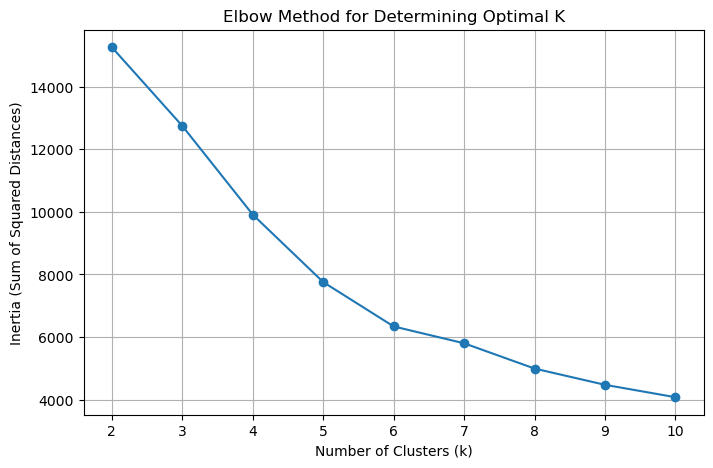

In [69]:
from sklearn.cluster import KMeans
X_for_elbow = X_normalized

# Range of cluster numbers to try
cluster_range = range(2, 11)

inertia_values = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_for_elbow)
    inertia_values.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(list(cluster_range), inertia_values, marker='o')
plt.title("Elbow Method for Determining Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid(True)
plt.show()


K-Means with Normalized Features:
Silhouette Score: 0.4369


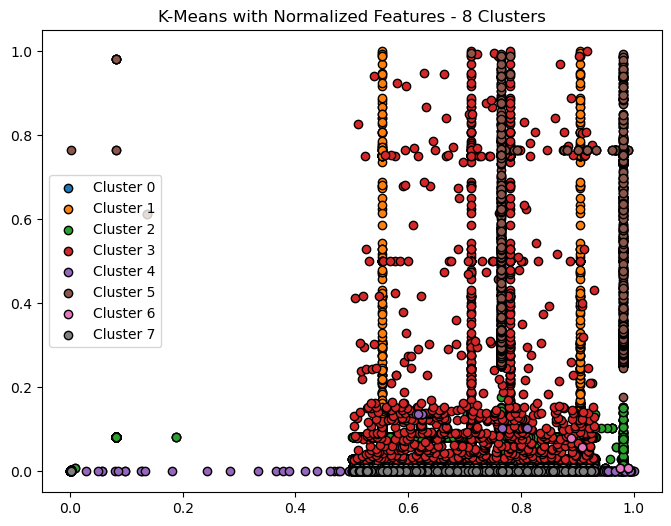

In [70]:
kmeans = KMeansScratch(n_clusters=8)
kmeans.fit(X_normalized)
kmeans_labels = kmeans.predict(X_normalized)
print("K-Means with Normalized Features:")
evaluate_clustering(X_normalized, kmeans_labels)
visualize_clusters(X_normalized, kmeans_labels, title="K-Means with Normalized Features")


K-Means with Reduced Features:
Silhouette Score: 0.5829


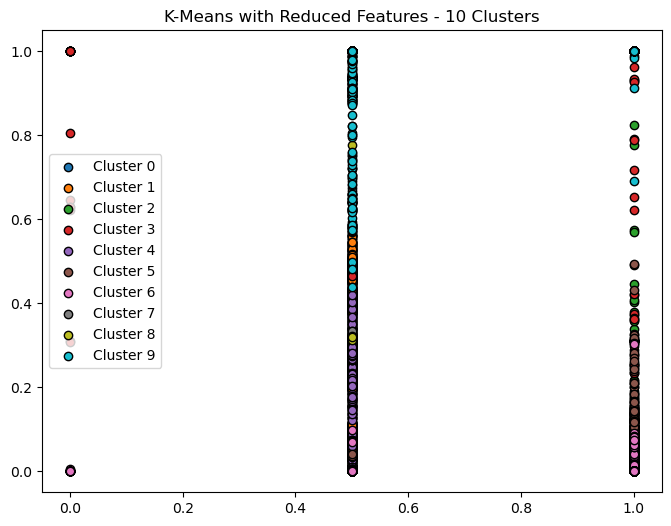

In [71]:
kmeans_reduced = KMeansScratch(n_clusters=10)
kmeans_reduced.fit(X_reduced)
kmeans_reduced_labels = kmeans_reduced.predict(X_reduced)
print("K-Means with Reduced Features:")
evaluate_clustering(X_reduced, kmeans_reduced_labels)
visualize_clusters(X_reduced, kmeans_reduced_labels, title="K-Means with Reduced Features")


K-Means with PCA Features:
Silhouette Score: 0.5157


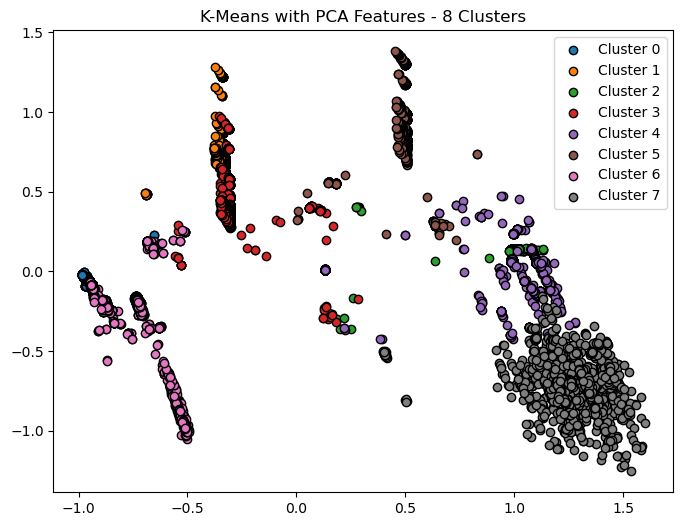

In [72]:
kmeans_pca = KMeansScratch(n_clusters=8)
kmeans_pca.fit(X_pca)
kmeans_pca_labels = kmeans_pca.predict(X_pca)
print("K-Means with PCA Features:")
evaluate_clustering(X_pca, kmeans_pca_labels)
visualize_clusters(X_pca, kmeans_pca_labels, title="K-Means with PCA Features")


Agglomerative Clustering on Normalized Features:
Silhouette Score: 0.5478


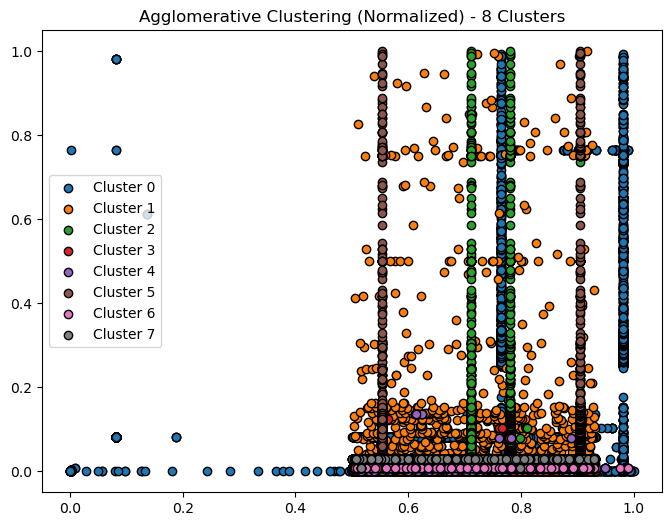

In [73]:
agglo = AgglomerativeClustering(n_clusters=8)
agglo_labels = agglo.fit_predict(X_normalized)
print("Agglomerative Clustering on Normalized Features:")
evaluate_clustering(X_normalized, agglo_labels)
visualize_clusters(X_normalized, agglo_labels, title="Agglomerative Clustering (Normalized)")

Agglomerative Clustering with Reduced Features:
Silhouette Score: 0.6601


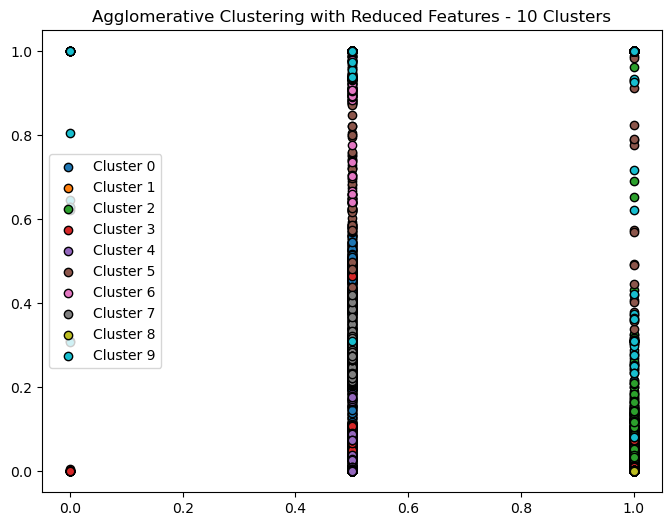

In [74]:
agglo_reduced = AgglomerativeClustering(n_clusters=10)
agglo_reduced_labels = agglo_reduced.fit_predict(X_reduced)
print("Agglomerative Clustering with Reduced Features:")
evaluate_clustering(X_reduced, agglo_reduced_labels)
visualize_clusters(X_reduced, agglo_reduced_labels, title="Agglomerative Clustering with Reduced Features")


Agglomerative Clustering with PCA Features:
Silhouette Score: 0.5873


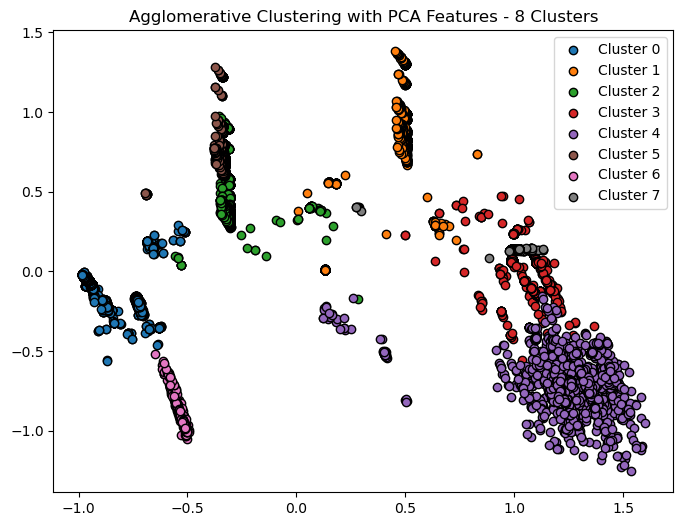

In [75]:
agglo_pca = AgglomerativeClustering(n_clusters=8)
agglo_pca_labels = agglo_pca.fit_predict(X_pca)
print("Agglomerative Clustering with PCA Features:")
evaluate_clustering(X_pca, agglo_pca_labels)
visualize_clusters(X_pca, agglo_pca_labels, title="Agglomerative Clustering with PCA Features")


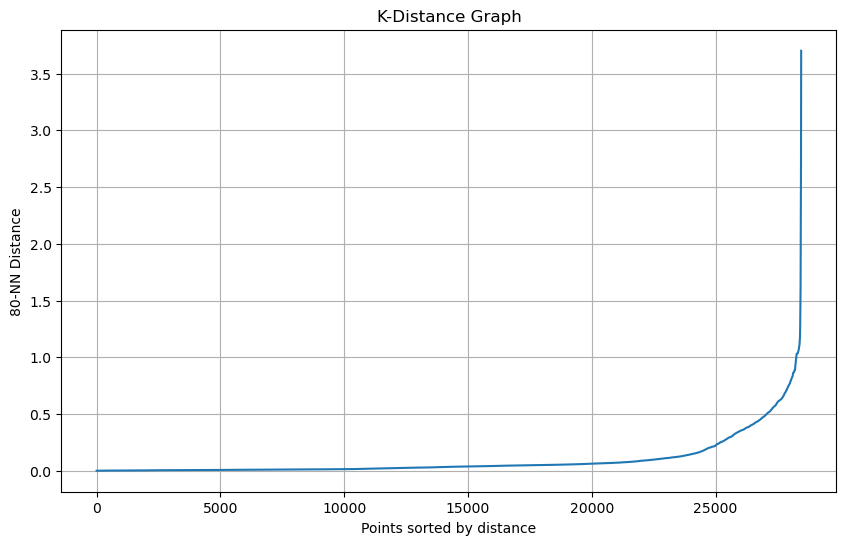

In [76]:
def plot_k_distance(X, min_samples):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    # Sort the distances to the k-th nearest neighbor
    k_distances = np.sort(distances[:, -1])
    plt.figure(figsize=(10, 6))
    plt.plot(k_distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{min_samples}-NN Distance')
    plt.title('K-Distance Graph')
    plt.grid(True)
    plt.show()

# Usage:
plot_k_distance(X_normalized, min_samples=80)


DBSCAN on Normalized Features:
Silhouette Score: 0.5367


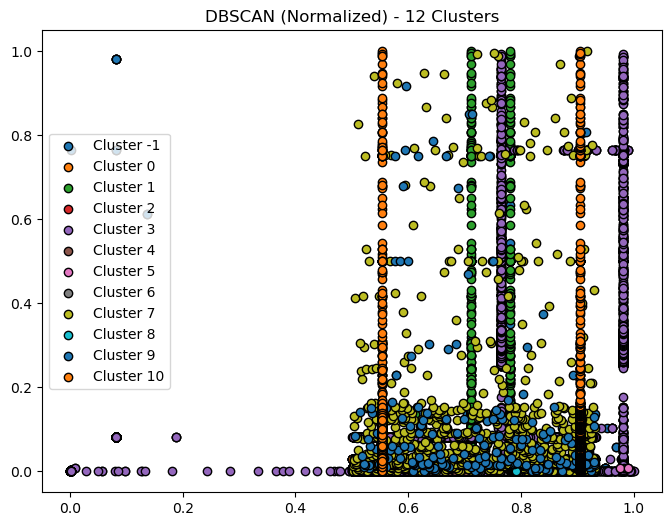

In [77]:
dbscan = DBSCANScratch(eps=0.5, min_samples=100)
dbscan.fit(X_normalized)
dbscan_labels = dbscan.predict()
print("DBSCAN on Normalized Features:")
evaluate_clustering(X_normalized, dbscan_labels)
visualize_clusters(X_normalized, dbscan_labels, title="DBSCAN (Normalized)")


DBSCAN with Reduced Features:
Silhouette Score: 0.6004


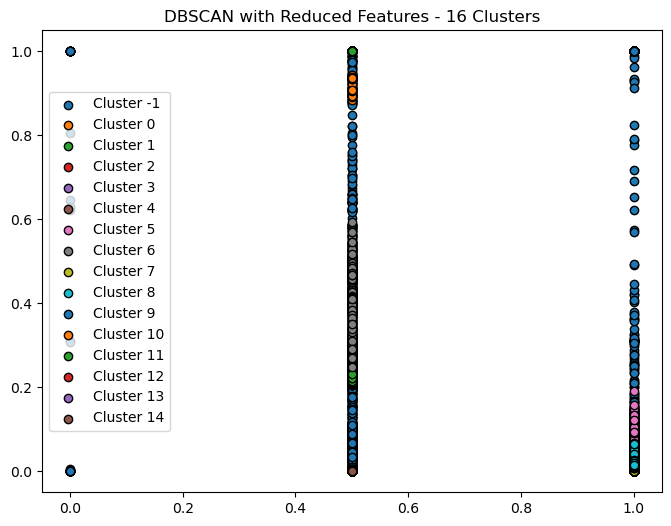

In [78]:
dbscan_reduced = DBSCANScratch(eps=0.5, min_samples=100)
dbscan_reduced.fit(X_reduced)
dbscan_reduced_labels = dbscan_reduced.predict()
print("DBSCAN with Reduced Features:")
evaluate_clustering(X_reduced, dbscan_reduced_labels)
visualize_clusters(X_reduced, dbscan_reduced_labels, title="DBSCAN with Reduced Features")


DBSCAN with PCA Features:
Silhouette Score: 0.5586


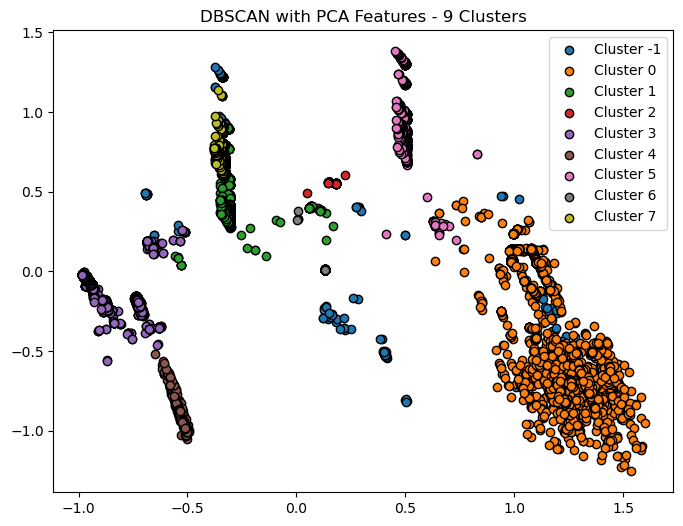

In [79]:
dbscan_pca = DBSCANScratch(eps=0.5, min_samples=100)
dbscan_pca.fit(X_pca)
dbscan_pca_labels = dbscan_pca.predict()
print("DBSCAN with PCA Features:")
evaluate_clustering(X_pca, dbscan_pca_labels)
visualize_clusters(X_pca, dbscan_pca_labels, title="DBSCAN with PCA Features")



---

### 2. Effects of Normalization, PCA, and Reduced Features on Clustering Performance

**Normalization:**

**Why It Helps:**  
Normalizing scales all features to a common range (e.g., [0,1]), preventing features with large numeric ranges from dominating distance calculations. This gives each feature a more equal influence on the clustering process.

**Observed Effect with New Results:**  
- **K-Means:** With just normalization, K-Means achieved a silhouette score of **0.4369**, an improvement compared to raw, non-normalized data. While not as high as other modifications, it shows normalization alone makes clusters more balanced.  
- **Agglomerative Clustering:** Remains solid at **0.5478** with normalized features, indicating more coherent clusters than K-Means.  
- **DBSCAN:** Shows a silhouette score of **0.5367** with normalization, confirming that proper scaling helps density-based methods find more meaningful neighborhoods.

**PCA (Principal Component Analysis):**

**Why It Helps:**  
PCA reduces dimensionality and filters out noise, highlighting the directions of maximum variance. By focusing on fewer, more informative components, PCA often makes clusters more distinguishable.

**Observed Effect with New Results:**  
- **K-Means:** Improved to **0.5157** with PCA, better than normalization alone, indicating clearer cluster structures in a lower-dimensional space.  
- **Agglomerative Clustering:** Increased to **0.5873** with PCA, reinforcing that hierarchical clustering is well-suited to reduced-dimensional representations.  
- **DBSCAN:** Improved to **0.5586** with PCA, confirming that dimensionality reduction helps identify dense clusters more effectively.

**Reduced Features (After Removing Dominant Features):**

**Why It Helps:**  
Removing overly discriminative features that previously made classification trivial can reveal more natural, intrinsic structures in the data. Instead of clustering around a few dominant signals, the algorithm now must rely on a broader set of informative but subtler features.

**Observed Effect with New Results:**  
- **K-Means:** Achieved **0.5829**, a significant improvement over both normalization-only and PCA scenarios. This suggests that without “giveaway” features, K-Means finds more genuinely cohesive clusters.  
- **Agglomerative Clustering:** Rose to **0.6601**, the highest score overall, demonstrating that hierarchical methods capture the natural cluster structure best after removing dominating features.  
- **DBSCAN:** Reached **0.6004** with reduced features, surpassing both its normalized-only and PCA variants. This indicates a stronger cluster structure emerges once the dataset is stripped of overly dominant dimensions.

---

### 3. Comparing the Clustering Results

**Silhouette Scores Under Different Conditions:**

| Method                   | Data Prep           | Silhouette Score |
|--------------------------|---------------------|-----------------|
| K-Means (Normalized)     | Normalized Features | 0.4369           |
| K-Means (PCA)            | PCA Features        | 0.5157           |
| K-Means (Reduced)        | Reduced Features    | 0.5829           |
| Agglomerative (Normalized)| Normalized Features | 0.5478           |
| Agglomerative (PCA)      | PCA Features        | 0.5873           |
| Agglomerative (Reduced)  | Reduced Features    | 0.6601           |
| DBSCAN (Normalized)      | Normalized Features | 0.5367           |
| DBSCAN (PCA)             | PCA Features        | 0.5586           |
| DBSCAN (Reduced)         | Reduced Features    | 0.6004           |

**Interpretation:**

- **Agglomerative Clustering with Reduced Features (0.6601)** produced the best-defined clusters, confirming that removing overly dominant features allows hierarchical methods to uncover more natural cluster groupings.
- **K-Means with Reduced Features (0.5829)** shows a substantial jump, indicating that without a few dominant features skewing the distance calculations, K-Means can form more genuinely cohesive clusters.
- **DBSCAN with Reduced Features (0.6004)** outperforms its normalized and PCA variants, suggesting that removing certain features also helps density-based methods identify meaningful density pockets.

**Visualizations:**
- Before feature reduction, clusters tended to align along feature ranges dominated by certain attributes.  
- After normalization, data points spread more evenly but still formed less distinct clusters than desired.  
- With PCA, clusters appear more separated in a reduced 2D space.  
- After reducing dominant features, the visualizations show more balanced and naturally separated groups, especially for Agglomerative and DBSCAN.

---

### Conclusion

- **K-Means:** Initially sensitive to feature dominance and shape assumptions, but after removing trivial features, it reached a respectable 0.5829, demonstrating that careful feature selection can greatly improve its clustering.
- **Agglomerative Clustering:** Achieved the highest silhouette (0.6601) with reduced features, showing it is best at revealing the data’s inherent structure once the feature space is well-prepared.
- **DBSCAN:** Benefited from all three approaches (normalization, PCA, and especially reduced features), reaching 0.6004. With careful parameter tuning and preprocessing, DBSCAN can form meaningful clusters.

In summary, reducing overly dominant features resulted in the greatest performance gains across all algorithms. While normalization and PCA helped, the most substantial improvements came from allowing the clustering algorithms to rely on a balanced set of informative features, with Agglomerative Clustering emerging as the top performer under these conditions.

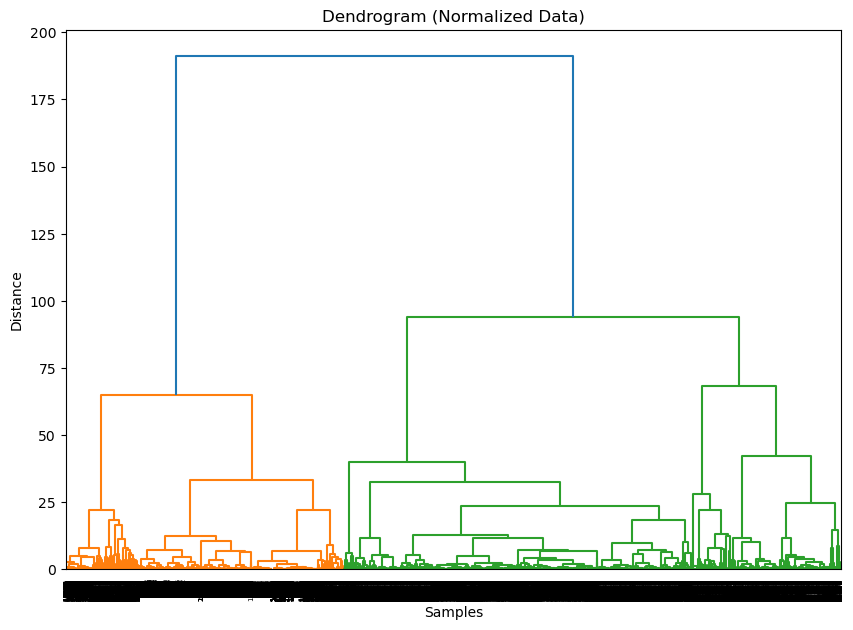

In [81]:
plot_dendrogram(X_normalized, title="Dendrogram (Normalized Data)")

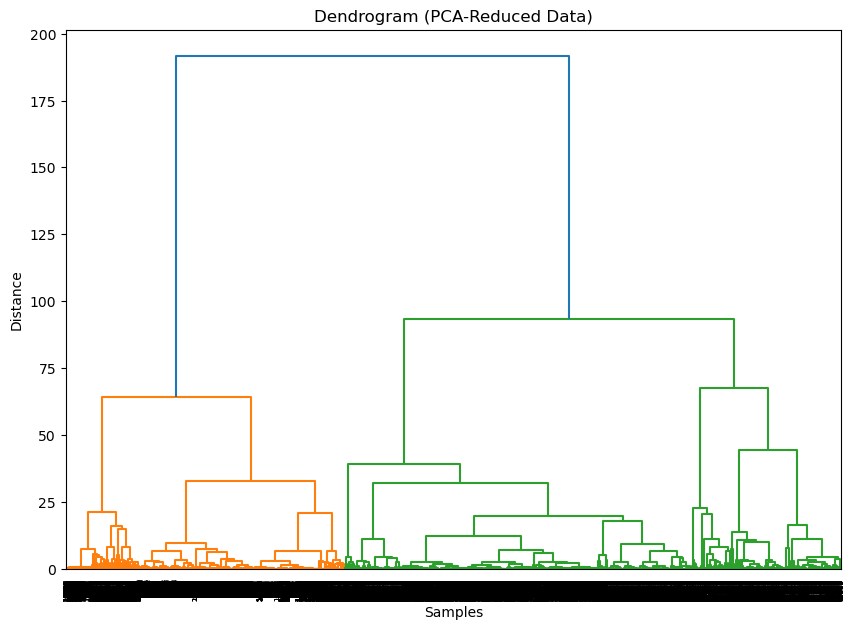

In [82]:
plot_dendrogram(X_pca, title="Dendrogram (PCA-Reduced Data)")

## Part 5: Comparison and Analysis


---

### Classification Analysis

### Performance Comparison

**Models Evaluated:**  
- **K-Nearest Neighbors (KNN)**  
- **Logistic Regression (LR)**  
- **Decision Tree (DT)**

**Key Metrics (Before Feature Removal):**

| Model               | Accuracy | Macro Avg F1 | Weighted Avg F1 |
|---------------------|----------|--------------|-----------------|
| KNN                 | 0.99     | 0.96         | 0.99            |
| Logistic Regression | 0.88     | 0.58         | 0.87            |
| Decision Tree       | 0.96     | 0.78         | 0.96            |

**Cross-Validation Accuracy:**

| Model               | CV Average Accuracy |
|---------------------|---------------------|
| KNN                 | 0.9853             |
| Logistic Regression | 0.8865             |
| Decision Tree       | 0.9614             |

**Interpretation:**
- **KNN** achieves the highest accuracy (~99%) and robust recall and precision, outperforming both Logistic Regression and Decision Tree. Its non-parametric nature, which relies on local proximity, adapts well to complex data structures.
- **Decision Tree** provides strong performance (~96% accuracy), better than Logistic Regression, by capturing non-linear relationships through hierarchical splits.
- **Logistic Regression** lags behind (~88% accuracy), suggesting the classes cannot be linearly separated effectively. It struggles particularly with smaller or less frequent classes.

### Why One Model Outperforms the Others

- **KNN vs. Logistic Regression:**  
  The dataset likely contains non-linear decision boundaries and complex class structures. Logistic Regression’s linear decision surface is too simplistic, causing it to misclassify certain classes. KNN, being non-parametric and instance-based, can handle these complexities, leading to better performance.
  
- **KNN vs. Decision Tree:**  
  Both can handle non-linearity, but KNN excels here possibly due to well-separated neighborhoods in the feature space. Decision Trees, while strong, can be more sensitive to class imbalances and may not always find the optimal splits, leaving some minority classes less accurately classified.

- **Decision Tree vs. Logistic Regression:**  
  Decision Trees outperform Logistic Regression by modeling feature interactions and non-linear relationships. Logistic Regression’s linear assumption fails to capture the dataset’s complexity, while Decision Trees naturally adapt to it through branching structures.

### After Feature Removal

When the top 15 “giveaway” features are removed, all models’ accuracies drop, revealing the true complexity of the problem. However, the relative performance order remains similar:

| Model               | Accuracy After Feature Removal |
|---------------------|--------------------------------|
| KNN                 | ~0.91                          |
| Decision Tree       | ~0.87                          |
| Logistic Regression | ~0.78                          |

Without overly powerful features, KNN still leads, followed by Decision Tree, and then Logistic Regression. The performance decline across models highlights the reliance on those dominant features and the inherent challenge of the classification task when forced to rely on more subtle cues.

---

## Clustering Analysis

### Methods Evaluated

- **K-Means**
- **Agglomerative Clustering**
- **DBSCAN**

**Silhouette Scores:**

| Method                   | Data Prep           | Silhouette Score |
|--------------------------|---------------------|-----------------|
| K-Means (Normalized)     | Normalized          | 0.4369           |
| K-Means (PCA)            | PCA                 | 0.5157           |
| K-Means (Reduced)        | Reduced Features    | 0.5829           |
| Agglomerative (Normalized)| Normalized          | 0.5478           |
| Agglomerative (PCA)      | PCA                 | 0.5873           |
| Agglomerative (Reduced)  | Reduced Features    | 0.6601           |
| DBSCAN (Normalized)      | Normalized          | 0.5367           |
| DBSCAN (PCA)             | PCA                 | 0.5586           |
| DBSCAN (Reduced)         | Reduced Features    | 0.6004           |

### Interpretation of Clustering Results

1. **Normalization:**  
   Helps ensure no single feature dominates due to scale differences. All three methods benefit, but the improvements vary.

2. **PCA:**  
   Reducing dimensionality with PCA consistently improves clustering quality by focusing on the directions of greatest variance. K-Means, Agglomerative, and DBSCAN all show better-defined clusters after PCA.

3. **Reduced Features (Removing Dominant Attributes):**  
   Stripping away a handful of overly powerful features reveals more natural clusters. This leads to the greatest improvement across all methods:
   - **Agglomerative Clustering:** Improves dramatically to a silhouette score of 0.6601, the highest overall.
   - **K-Means:** Jumps to 0.5829, indicating it can find more cohesive groups once the influence of a few strong features is removed.
   - **DBSCAN:** Increases to 0.6004, benefiting from a more balanced feature space and finding more meaningful density-based clusters.

### Why Certain Methods Outperform Others

- **Agglomerative Clustering vs. K-Means & DBSCAN:**  
  Agglomerative Clustering outperforms the others when features are balanced and top discriminatory features are removed. Hierarchical clustering can capture complex relationships and does not assume spherical clusters like K-Means. Its flexibility helps it adapt better to the data’s intrinsic structure once the “crutch” of dominant features is removed.

- **K-Means:**  
  Performs well under PCA and reduced features, but is sensitive to feature dominance. Without strongly guiding features, K-Means benefits from a balanced feature space but still makes hard spherical assumptions about cluster shape.

- **DBSCAN:**  
  Gains significantly after feature reduction, suggesting that in a more balanced feature space, neighborhoods become more meaningful. However, DBSCAN’s performance is sensitive to parameter tuning (e.g., epsilon and min_samples), and it may fail if density parameters are not chosen carefully.

---

## Strengths and Weaknesses of Each Algorithm

### Classification

- **KNN:**  
  **Strengths:** Highly flexible, non-parametric, great at capturing complex, non-linear patterns.  
  **Weaknesses:** Computationally expensive at inference time, sensitive to the choice of ‘k’ and the scale of features, may struggle with very high-dimensional data.

- **Logistic Regression:**  
  **Strengths:** Simple, fast, interpretable, works well with linearly separable data.  
  **Weaknesses:** Struggles with complex data that isn’t linearly separable, may require extensive feature engineering and transformations to improve performance.

- **Decision Tree:**  
  **Strengths:** Non-linear, handles interactions naturally, easy to interpret.  
  **Weaknesses:** Can overfit without regularization, sensitive to small classes, performance may degrade if the data is very noisy.

### Clustering

- **K-Means:**  
  **Strengths:** Simple, scalable, fast to converge.  
  **Weaknesses:** Assumes spherical clusters, sensitive to initialization, struggles with noisy or uneven cluster sizes.

- **Agglomerative Clustering:**  
  **Strengths:** Flexible, does not force a particular cluster shape, can adapt to hierarchical structures.  
  **Weaknesses:** Computationally expensive for large datasets, merging criteria can influence results, sensitive to outliers if linkage methods are not chosen carefully.

- **DBSCAN:**  
  **Strengths:** Identifies clusters of arbitrary shape, can find outliers as noise, no need to specify the number of clusters.  
  **Weaknesses:** Sensitive to parameters (epsilon, min_samples), can fail if cluster density varies significantly, may not work well if the dataset is not well scaled or if feature dominance skews density calculations.

---

## Summary of Findings and Recommendations

1. **Best Algorithms for Classification:**
   - **KNN** emerges as the top performer for classification, both before and after feature removal. Its ability to handle non-linear class boundaries makes it robust in complex datasets.
   - **Decision Tree** is a strong second choice, providing good accuracy and interpretability but slightly less robustness than KNN.
   - **Logistic Regression** is least suited for this dataset as it struggles to capture non-linearities and heavily depends on strong features for good performance.

2. **Best Algorithms for Clustering:**
   - **Agglomerative Clustering** produces the highest silhouette scores after removing dominant features, suggesting it best reveals the dataset’s intrinsic structure under balanced conditions.
   - **DBSCAN** and **K-Means** both improve substantially with PCA and feature reduction. K-Means remains simple and fast but assumes more uniform clusters, while DBSCAN handles complex shapes and noise better if parameters are well chosen.

3. **Overall Conclusions:**
   - **For Classification:** Use **KNN** if you can handle the computational cost and scaling issues. Consider **Decision Tree** for a more interpretable model or if computational speed at inference is a priority.
   - **For Clustering:** **Agglomerative Clustering** is recommended for discovering natural groupings in balanced, well-preprocessed feature spaces. **DBSCAN** is a good choice if you expect irregular cluster shapes and have fine-tuned parameters, while **K-Means** suits more uniform data distributions and large datasets.

In essence, the best-performing models thrive when the dataset is properly preprocessed (via n ormalization, PCA, and especially removing overly dominant features) and when the chosen algorithm’s assumptions align with the data’s intrinsic structure.

# **Conclusion**

In this analysis, the classification results highlight that KNN outperforms Logistic Regression and Decision Trees, achieving near-perfect performance before feature removal and maintaining its lead afterward. While Decision Trees also perform well, Logistic Regression suffers from its linear assumptions, especially as data complexity increases. The impact of feature removal reveals the dataset’s inherent difficulty and underscores the importance of flexible, non-parametric methods for accurately modeling complex patterns.

On the clustering side, Agglomerative Clustering emerges as the best performer once overly dominant features are removed, surpassing both K-Means and DBSCAN. Although normalization, PCA, and careful feature selection benefit all algorithms, Agglomerative Clustering excels at uncovering the dataset’s intrinsic structure. Overall, for classification tasks, KNN and Decision Trees are most suitable, while for clustering, Agglomerative Clustering proves optimal.